<a href="https://colab.research.google.com/github/Yongshilin/forage/blob/main/Forage_Quantium_DA_task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Forage_Quantium_DA_task2 by Yongshi Lin

In [ ]:
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import t

## Import Dataset

In [ ]:
qvi_df = pd.read_csv('/content/QVI_data.csv')
df = qvi_df.copy() # use copy version of the original data
df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [ ]:
df.shape

(264834, 12)

In [ ]:
df.dtypes

LYLTY_CARD_NBR        int64
DATE                 object
STORE_NBR             int64
TXN_ID                int64
PROD_NBR              int64
PROD_NAME            object
PROD_QTY              int64
TOT_SALES           float64
PACK_SIZE             int64
BRAND                object
LIFESTAGE            object
PREMIUM_CUSTOMER     object
dtype: object

## Select Control Stores
The client has selected store numbers 77, 86 and 88 as trial stores and want control stores to be established stores that are operational for the entire observation period.
We would want to match trial stores to control stores that are similar to the trial
store prior to the trial period of Feb 2019 in terms of :
- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer

Let's first create the metrics of interest and filter to stores that are present throughout the pre-trial period.
(https://dataanddesign.substack.com/p/understanding-metrics-of-interest)

##### Add a new month ID column. Calculate these measures over time for each store.

In [ ]:
# convert DATE column's data type to date format
df['DATE'] = pd.to_datetime(df['DATE'])
df['DATE'].dtypes

dtype('<M8[ns]')

In [ ]:
# Add a new month ID column in the data with the format yyyymm
df['MonthID'] = df['DATE'].dt.strftime('%Y%m')  #convert to string format
df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,MonthID
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,201810
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,201809
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,201903
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,201903
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,201811


##### Next, we define the measure calculations to use during the analysis. For each store and month, calculate total sales, number of customers,transactions per customer, chips per customer and the average price per unit.

### Monthly performance of each store

In [ ]:
# Aggregate metrics
monthly_df = df.groupby(['STORE_NBR', 'MonthID']).agg(
    Monthly_Sales = ('TOT_SALES', 'sum'),   # monthly total sales
    nCustomers = ('LYLTY_CARD_NBR', 'nunique'),  # number of customers
    Monthly_Trans =  ('TXN_ID', 'nunique'),  # Number of unique TXN_ID
    Total_Prod_Qty = ('PROD_QTY', 'sum')
).reset_index()

# Calculate derived metrics
monthly_df['nTxnPerCust'] = monthly_df['Monthly_Trans'] / monthly_df['nCustomers']
monthly_df['nChipsPerTxn'] = monthly_df['Total_Prod_Qty'] / monthly_df['Monthly_Trans']
monthly_df['avgPricePerUnit'] = monthly_df['Monthly_Sales'] / monthly_df['Total_Prod_Qty']

In [ ]:
# Filter to stores with full observation periods
month_count = monthly_df.groupby('STORE_NBR')['MonthID'].nunique().reset_index()
stores_fullob = month_count[month_count['MonthID'] == 12]['STORE_NBR']
fullob_df = monthly_df[monthly_df['STORE_NBR'].isin(stores_fullob)]
fullob_df.head()

,STORE_NBR,MonthID,Monthly_Sales,nCustomers,Monthly_Trans,Total_Prod_Qty,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,52,62,1.061224,1.192308,3.337097
1,1,201808,176.1,42,43,54,1.023810,1.255814,3.261111
2,1,201809,278.8,59,62,75,1.050847,1.209677,3.717333
3,1,201810,188.1,44,45,58,1.022727,1.288889,3.243103
4,1,201811,192.6,46,47,57,1.021739,1.212766,3.378947


In [ ]:
# Filter to the pre-trial period with full observation periods
pretrial_df = monthly_df[(monthly_df['MonthID'] < '201902') & (monthly_df['STORE_NBR'].isin(stores_fullob))]
pretrial_df.head()

,STORE_NBR,MonthID,Monthly_Sales,nCustomers,Monthly_Trans,Total_Prod_Qty,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,52,62,1.061224,1.192308,3.337097
1,1,201808,176.1,42,43,54,1.023810,1.255814,3.261111
2,1,201809,278.8,59,62,75,1.050847,1.209677,3.717333
3,1,201810,188.1,44,45,58,1.022727,1.288889,3.243103
4,1,201811,192.6,46,47,57,1.021739,1.212766,3.378947


In [ ]:
# Filter to the trial period with full observation periods
trial_df = monthly_df[(monthly_df['MonthID'] >= '201902') & (monthly_df['STORE_NBR'].isin(stores_fullob))]
trial_df.head()

,STORE_NBR,MonthID,Monthly_Sales,nCustomers,Monthly_Trans,Total_Prod_Qty,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
7,1,201902,225.4,52,55,65,1.057692,1.181818,3.467692
8,1,201903,192.9,45,49,58,1.088889,1.183673,3.325862
9,1,201904,192.9,42,43,57,1.023810,1.325581,3.384211
10,1,201905,221.4,46,51,66,1.108696,1.294118,3.354545
11,1,201906,174.1,42,42,53,1.000000,1.261905,3.284906


##### Now we need to work out a way of ranking how similar(calculate how correlated the performance) each potential control store is to the trial store. Create a function to calculate correlation for a measure for each trial store and control store pair, looping through each control store.

### Function for Pearson Correlation Coefficient

##### Let's define inputTable as a metric table with potential comparison stores, metricCol as the store metric used to calculate correlation on, and storeComparison as the store number of the trial store.

In [ ]:
# Create function to calculate correlation
def calc_correlation(input_table, metric_col, store_comparison):
    calc_corr_table = pd.DataFrame(columns = ['Store1', 'Store2', 'Corr_Measure'])  #create an empty dataframe to store the results
    # get unique store numbers excluding the trial store
    store_numbers = input_table['STORE_NBR'].unique()
    store_numbers = store_numbers[store_numbers != store_comparison]

    #loop through each control store
    for store in store_numbers:
        # extract data using boolean masking
        trial_store_data = input_table[input_table['STORE_NBR'] == store_comparison][metric_col].reset_index(drop = True)
        control_store_data = input_table[input_table['STORE_NBR'] == store][metric_col].reset_index(drop = True)  #filter the store number (when it is True)

    # Ensure both stores have the same length of data for correlation
        if len(trial_store_data) == len(control_store_data) and len(trial_store_data) > 1:
            corr_measure = trial_store_data.corr(control_store_data)

        calculated_measure = pd.DataFrame({
            'Store1': [store_comparison],
            'Store2': [store],
            'Corr_Measure': [corr_measure]})
        calc_corr_table = pd.concat([calc_corr_table, calculated_measure], ignore_index=True)

    return calc_corr_table

##### Apart from correlation, we can also calculate a standardised metric based on the absolute difference between the trial store's performance and each control store's performance.

### Function for Magnitude Distance

In [ ]:
# Create function to calculate magnitude distance, looping through each control store.
def calc_magnitude_distance(input_table, metric_col, store_comparison):
    calc_dist_table = pd.DataFrame(columns = ['Store1', 'Store2', 'YearMonth', 'Measure']) #create an empty dataframe to store the data
    store_numbers = input_table['STORE_NBR'].unique()
    store_numbers = store_numbers[store_numbers != store_comparison]

    # Step 1: Loop through each control store to calculate magnitude distance
    for store in store_numbers:
        # Extract data for the trial store and the control store
        trial_store_data = input_table[input_table['STORE_NBR'] == store_comparison].reset_index(drop=True)
        control_store_data = input_table[input_table['STORE_NBR'] == store].reset_index(drop=True)
        # Ensure both stores have the same length of data for distance calculation
        if len(trial_store_data) == len(control_store_data) and len(trial_store_data) > 1:
        # Calculate magnitude distance
            calculated_measure = pd.DataFrame({
            'Store1': [store_comparison]*len(trial_store_data),  #to clearly identify which stores are being compared in each row.
            'Store2': [store]*len(trial_store_data),  #to clearly identify which stores are being compared in each row.
            'YearMonth': trial_store_data['MonthID'],
            'Measure': abs(trial_store_data[metric_col] - control_store_data[metric_col])            })
            calc_dist_table = pd.concat([calc_dist_table, calculated_measure], ignore_index=True)

    # Step 2: Normalize the magnitude distance measure/ Standardize magnitude distance so that the measure ranges from 0 to 1
    min_max_dist = calc_dist_table.groupby(['Store1','YearMonth'])['Measure'].agg(min_dist = 'min', max_dist = 'max').reset_index()
    dist_table = pd.merge(calc_dist_table, min_max_dist, on = ['Store1','YearMonth'])
    dist_table['MagnitudeMeasure'] = 1 - (dist_table['Measure']-dist_table['min_dist']) / (dist_table['max_dist']-dist_table['min_dist']) # normalised distance measure

    # Step 3: Aggregate the magnitude measure
    final_dist_table = dist_table.groupby(['Store1', 'Store2'])['MagnitudeMeasure'].mean().reset_index()

    return final_dist_table

# Trial store 77

### Use functions to calculate metrics

##### Now use the functions to select control stores, based on how similar monthly total sales in dollar amounts and monthly number of customers are to the trial stores. So we will need to use our functions to get four scores, two for each of total sales and total customers.

In [ ]:
trial_store = 77
# calculate correlations of monthly total sales against store 77
corr_nSales = calc_correlation(pretrial_df,'Monthly_Sales',trial_store)
corr_nSales.head(3)

,Store1,Store2,Corr_Measure
0,77,1,0.075218
1,77,2,-0.263079
2,77,3,0.806644


In [ ]:
# calculate correlations of monthly number of customers against store 77
corr_nCust = calc_correlation(pretrial_df,'nCustomers',trial_store)
corr_nCust.head(3)

,Store1,Store2,Corr_Measure
0,77,1,0.322168
1,77,2,-0.572051
2,77,3,0.834207


In [ ]:
# calculating magnitude distance of monthly total sales against store 77
magnitude_nSales = calc_magnitude_distance(pretrial_df,'Monthly_Sales',trial_store)
magnitude_nSales.head(3)

,Store1,Store2,MagnitudeMeasure
0,77,1,0.955061
1,77,2,0.939318
2,77,3,0.354963


In [ ]:
# calculating magnitude distance of monthly number of customers against store 77
magnitude_nCust = calc_magnitude_distance(pretrial_df,'nCustomers',trial_store)
magnitude_nCust.head(3)

,Store1,Store2,MagnitudeMeasure
0,77,1,0.940321
1,77,2,0.924638
2,77,3,0.345067


### Create a combined score composed of correlation and magnitude.
Let's take a simple average of the correlation and magnitude scores for each
driver. Note that if we consider it more important for the trend of the drivers to be similar, we can increase the weight of the correlation score (a simple average gives a weight of 0.5 to the corr_weight) or if we consider the absolute size of the drivers to be more important, we can lower the weight of the correlation score.

Hint: A simple average on the scores would be 0.5 * corr_measure + 0.5 *
mag_measure.


In [ ]:
corr_weight = 0.5

# first merging the correlations table with the magnitude table.
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on = ['Store1', 'Store2'])
score_nCust = pd.merge(corr_nCust, magnitude_nCust, on = ['Store1', 'Store2'])

score_nSales['scoreNSales'] = corr_weight * score_nSales['Corr_Measure'] + (1 - corr_weight) * score_nSales['MagnitudeMeasure']
score_nCust['scoreNCust'] = corr_weight * score_nCust['Corr_Measure'] + (1 - corr_weight) * score_nCust['MagnitudeMeasure']

##### Now we have a score for each of total number of sales and number of customers. Let’s combine the two via a simple average.

In [ ]:
# merge the sales scores and customer scores into a single table
score_control = pd.merge(score_nSales, score_nCust, on = ['Store1', 'Store2'], suffixes = ('_Sales', '_Cust'))
score_control['Final_Control_Score'] = score_control['scoreNSales']*0.5 + score_control['scoreNCust']*0.5
score_control.head()

,Store1,Store2,Corr_Measure_Sales,MagnitudeMeasure_Sales,scoreNSales,Corr_Measure_Cust,MagnitudeMeasure_Cust,scoreNCust,Final_Control_Score
0,77,1,0.075218,0.955061,0.515139,0.322168,0.940321,0.631244,0.573192
1,77,2,-0.263079,0.939318,0.338120,-0.572051,0.924638,0.176294,0.257207
2,77,3,0.806644,0.354963,0.580803,0.834207,0.345067,0.589637,0.58522
3,77,4,-0.263300,0.177414,-0.042943,-0.295639,0.189579,-0.05303,-0.047986
4,77,5,-0.110652,0.554066,0.221707,0.370659,0.481199,0.425929,0.323818


##### The store with the highest score is then selected as the control store since it is most similar to the trial store.

In [ ]:
score_control = score_control.sort_values(by = 'Final_Control_Score', ascending = False).head()
score_control

,Store1,Store2,Corr_Measure_Sales,MagnitudeMeasure_Sales,scoreNSales,Corr_Measure_Cust,MagnitudeMeasure_Cust,scoreNCust,Final_Control_Score
220,77,233,0.903774,0.987091,0.945433,0.990358,0.992773,0.991566,0.968499
38,77,41,0.783232,0.966917,0.875075,0.844219,0.974639,0.909429,0.892252
15,77,17,0.842668,0.882314,0.862491,0.747308,0.962495,0.854902,0.858696
240,77,254,0.577108,0.924468,0.750788,0.916208,0.937131,0.92667,0.838729
107,77,115,0.689159,0.934576,0.811868,0.718882,0.965916,0.842399,0.827133


#### Summary: Store 233 is the most appropriate control store for store 77, because it has the highest final control score.

##### Now that we have found a control store, let’s check visually if the drivers are indeed similar in the pre-trial period.

### Visual checks on trends based on the drivers

In [ ]:
# define trial store and control tore pair
trial_store = 77
control_store = 233

In [ ]:
# Define store type and visualize
fullob_df = fullob_df.copy()
pretrial_df = pretrial_df.copy()

fullob_df['Store_Type'] = fullob_df['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other Stores'))

pretrial_df['Store_Type'] = pretrial_df['STORE_NBR'].apply(
        lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other Stores'))

In [ ]:
# Calculate total sales mean by MonthID and Store_type
past_sales = pretrial_df.groupby(['MonthID', 'Store_Type'])['Monthly_Sales'].mean().reset_index()

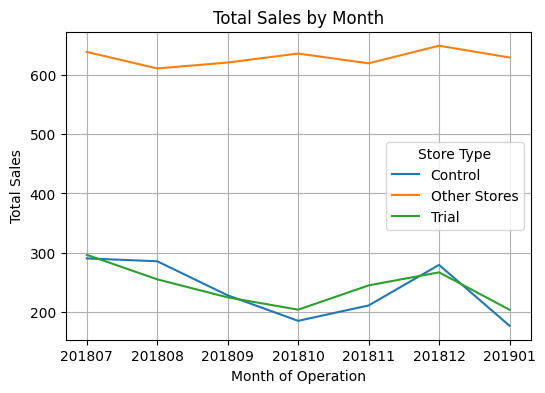

In [ ]:
plt.figure(figsize=(6, 4))
for store_type, group in past_sales.groupby('Store_Type'):  #define 'group' will be a DataFrame that contains all rows in the same store types(3 types here)
    plt.plot(group['MonthID'], group['Monthly_Sales'], label=store_type) #point the x-axis data, y-asix data and lable for the plot.
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.title('Total Sales by Month')
plt.legend(title='Store Type')
plt.grid(True)
plt.show()

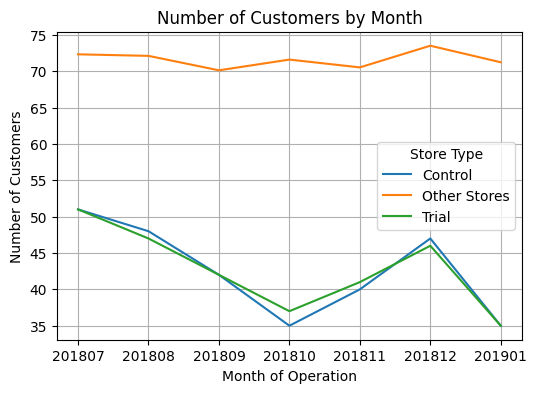

In [ ]:
# Visual checks on trends based on the drivers (number of customers)

# Calculate number of customers mean by MonthID and Store_type
past_cust = pretrial_df.groupby(['MonthID', 'Store_Type'])['nCustomers'].mean().reset_index()

# plot the result
plt.figure(figsize=(6, 4))
for store_type, group in past_cust.groupby('Store_Type'):
    plt.plot(group['MonthID'], group['nCustomers'], label=store_type)

plt.xlabel('Month of Operation')
plt.ylabel('Number of Customers')
plt.title('Number of Customers by Month')
plt.legend(title='Store Type')
plt.grid(True)
plt.show()

#### Summary: From the graphs, we can assure that  the drivers(monthly total sales, monthly number of customers) for the trial and control stores(store 77 & 233) are indeed similar before the trial period.

## Assessment of Trial (Monthly Total Sales)
The trial period goes from the start of February 2019 to April 2019. We now want to see if there has been an uplift in overall chip sales.

Start with scaling the control store's sales to a level similar to control
for any differences between the two stores outside of the trial period.

In [ ]:
## Scale pre-trial control sales to match pre-trial trial store sales （201807-201901）
#measure_overtime_sales only include full observation data during pre-trial period

# Filter data for trial store and control store for pre-trial period
trial_store_sales = pretrial_df[(pretrial_df['STORE_NBR'] == trial_store)].copy()
control_store_sales = pretrial_df[(pretrial_df['STORE_NBR'] == control_store)].copy()

# Calculate the total sales for trial store and control store for the scaling factor
trial_store_totsales = trial_store_sales['Monthly_Sales'].sum()
control_store_totsales = control_store_sales['Monthly_Sales'].sum()
scalingF_control_sales = trial_store_totsales / control_store_totsales

# Apply the scaling factor to the control store sales in the dataset
control_store_sales['Scaled_Ctl_Sales'] = control_store_sales.apply(
    lambda x: x['Monthly_Sales'] * scalingF_control_sales if x['STORE_NBR'] == control_store else '-', axis=1)
control_store_sales

,STORE_NBR,MonthID,Monthly_Sales,nCustomers,Monthly_Trans,Total_Prod_Qty,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Store_Type,Scaled_Ctl_Sales
2699,233,201807,290.7,51,54,88,1.058824,1.629630,3.303409,Control,297.565550
2700,233,201808,285.9,48,50,80,1.041667,1.600000,3.573750,Control,292.652187
2701,233,201809,228.6,42,45,70,1.071429,1.555556,3.265714,Control,233.998916
2702,233,201810,185.7,35,36,56,1.028571,1.555556,3.316071,Control,190.085733
2703,233,201811,211.6,40,41,62,1.025000,1.512195,3.412903,Control,216.597421
2704,233,201812,279.8,47,50,75,1.063830,1.500000,3.730667,Control,286.408121
2705,233,201901,177.5,35,35,47,1.000000,1.342857,3.776596,Control,181.692071


In [ ]:
# Extract the columns we want, and calculate the percentage difference for pre-trial period
# Rename columns to avoid conflicts
trial_store_sales = trial_store_sales.rename(columns={'Monthly_Sales':'Trial_Sales', 'STORE_NBR':'Trial_Store_NBR'})
control_store_sales = control_store_sales.rename(columns={'Scaled_Ctl_Sales':'Control_Sales', 'STORE_NBR':'Ctl_Store_NBR'})

# Merge the two data frames on 'MonthID'
diff_pretrial = pd.merge(trial_store_sales[['MonthID', 'Trial_Sales', 'Trial_Store_NBR']],
                   control_store_sales[['MonthID', 'Control_Sales', 'Ctl_Store_NBR']],
                   on='MonthID')

# Calculate the percentage difference
diff_pretrial['Sales_Percent_Diff'] = (diff_pretrial['Trial_Sales']-diff_pretrial['Control_Sales']) / diff_pretrial['Control_Sales'] #set control store'sales as baseline for comparing

diff_pretrial[['MonthID','Ctl_Store_NBR','Control_Sales','Trial_Store_NBR','Trial_Sales','Sales_Percent_Diff']]

,MonthID,Ctl_Store_NBR,Control_Sales,Trial_Store_NBR,Trial_Sales,Sales_Percent_Diff
0,201807,233,297.565550,77,296.8,-0.002573
1,201808,233,292.652187,77,255.5,-0.126950
2,201809,233,233.998916,77,225.2,-0.037602
3,201810,233,190.085733,77,204.5,0.075830
4,201811,233,216.597421,77,245.3,0.132516
5,201812,233,286.408121,77,267.3,-0.066716
6,201901,233,181.692071,77,204.4,0.124980


##### Now that we have comparable sales figures for the control store, we can calculate the percentage difference between the scaled control sales and the trial store's sales during the trial period(201902-201904).

In [ ]:
# Filter data for the trial period (201902-201904) for both trial and control stores
trial_store_sales_t = fullob_df[(fullob_df['STORE_NBR'] == trial_store)
                              & (fullob_df['MonthID'].astype(int) < 201905)
                              & (fullob_df['MonthID'].astype(int) > 201901)].copy()
control_store_sales_t = fullob_df[(fullob_df['STORE_NBR'] == control_store)
                                & (fullob_df['MonthID'].astype(int) < 201905)
                                & (fullob_df['MonthID'].astype(int) > 201901)].copy()

# Apply the scaling factor to the control store sales during trial period
control_store_sales_t['Scaled_Ctl_Sales'] = control_store_sales_t['Monthly_Sales'] * scalingF_control_sales

In [ ]:
# Rename columns to avoid conflicts
trial_store_sales_t = trial_store_sales_t.rename(columns={'Monthly_Sales':'Trial_Sales', 'STORE_NBR':'Trial_Store_NBR'})
control_store_sales_t = control_store_sales_t.rename(columns={'Scaled_Ctl_Sales':'Control_Sales', 'STORE_NBR':'Ctl_Store_NBR'})

# Merge the two data frames on 'MonthID'
diff_trial = pd.merge(trial_store_sales_t[['MonthID', 'Trial_Sales', 'Trial_Store_NBR']],
                   control_store_sales_t[['MonthID', 'Control_Sales', 'Ctl_Store_NBR']],
                   on='MonthID')

# Calculate the percentage difference
diff_trial['Sales_Percent_Diff'] = (diff_trial['Trial_Sales']-diff_trial['Control_Sales']) / diff_trial['Control_Sales'] #set control store'sales as baseline for comparing

diff_trial[['MonthID','Ctl_Store_NBR','Control_Sales','Trial_Store_NBR','Trial_Sales','Sales_Percent_Diff']].head()

,MonthID,Ctl_Store_NBR,Control_Sales,Trial_Store_NBR,Trial_Sales,Sales_Percent_Diff
0,201902,233,249.762622,77,235.0,-0.059107
1,201903,233,203.802205,77,278.5,0.366521
2,201904,233,162.345704,77,263.5,0.623080


##### As our null hypothesis is that the trial period is the same as the pre-trial period, let's take the standard deviation based on the scaled percentage difference in the pre-trial period.
- Null Hypothesis (𝐻0): The trial period is no different from the pre-trial period.

- Alternative Hypothesis (𝐻1): The trial period is different from the pre-trial period.

#### 1. Calculate the Standard Deviation for Pre-Trial Period:

In [ ]:
std_dev_pt = diff_pretrial['Sales_Percent_Diff'].std()
print(f"Standard deviation for pre-trial period: {std_dev_pt:.4f}")

Standard deviation for pre-trial period: 0.0996


##### We will test with a null hypothesis of there being 0 difference between trial and control stores.

- Calculate the t-values for the trial months.

- Find the 95th percentile of the t distribution with the appropriate degrees of freedom.

- Check whether the hypothesis is statistically significant.

Hint: The test statistic here is (x - u)/standard deviation

#### 2. Calculate the T-values for the Trial Months:

In [ ]:
# Population mean (null hypothesis)
mu = 0

# Calculate t-values
t_values = (diff_trial['Sales_Percent_Diff'] - mu) / std_dev_pt # Use the sample standard deviation for pre-trial period, which provides a benchmark to measure deviations during the trial period.

# Display t-values
diff_trial.loc[:,'T_Value'] = t_values
diff_trial

,MonthID,Trial_Sales,Trial_Store_NBR,Control_Sales,Ctl_Store_NBR,Sales_Percent_Diff,T_Value
0,201902,235.0,77,249.762622,233,-0.059107,-0.593520
1,201903,278.5,77,203.802205,233,0.366521,3.680430
2,201904,263.5,77,162.345704,233,0.623080,6.256669


#### 3. Determine the Critical T-Value:

In [ ]:
# Degrees of freedom (df) ~ Pre-Trial Period
dof = len(diff_pretrial) - 1 # 7 months of data - 1

# Two-tailed test: significance level = 0.05
alpha = 0.05
t_critical = t.ppf(1 - alpha, dof)
print(f"Critical t-value for one-tailed test with df={dof}: {t_critical:.4f}")

Critical t-value for one-tailed test with df=6: 1.9432


#### 4. Compare the T-Values:
We can observe that the t-value in March and April is much larger than the critical t-value with 95% confidence interval.

It could be the increase in sales in the trial store in March and April is statistically greater than in the control store.

#### 5. Visual Version of Comparison:
Let's create a more visual version of this by plotting the sales of the control store, the sales of the trial stores and the 95th percentile value of sales of the control store.

In [ ]:
## Method1: merge the percentage difference tables of pre-trial & trial period vertically (201807-201904)
#percentdiff = pd.concat([diff_pretrial, diff_trial], axis=0)

In [ ]:
## Method2: Filter data for all months with full observation periods and see the whole trend. (201807-201906)
trial_store_sales_f = fullob_df[fullob_df['STORE_NBR'] == trial_store].copy()
control_store_sales_f = fullob_df[fullob_df['STORE_NBR'] == control_store].copy()

# Apply the scaling factor to the control store sales during trial period
control_store_sales_f['Scaled_Ctl_Sales'] = control_store_sales_f['Monthly_Sales'] * scalingF_control_sales

# Rename columns to avoid conflicts
trial_store_sales_f = trial_store_sales_f.rename(columns={'Monthly_Sales':'Trial_Sales', 'STORE_NBR':'Trial_Store_NBR'})
control_store_sales_f = control_store_sales_f.rename(columns={'Scaled_Ctl_Sales':'Control_Sales', 'STORE_NBR':'Ctl_Store_NBR'})

# Merge the two data frames on 'MonthID'
diff_full = pd.merge(trial_store_sales_f[['MonthID', 'Trial_Sales', 'Trial_Store_NBR']],
                   control_store_sales_f[['MonthID', 'Control_Sales', 'Ctl_Store_NBR']],
                   on='MonthID')

# Calculate the percentage difference
diff_full['Percent_Diff'] = (diff_full['Trial_Sales']-diff_full['Control_Sales']) / diff_full['Control_Sales'] #set control store'sales as baseline for comparing

diff_full[['MonthID','Ctl_Store_NBR','Control_Sales','Trial_Store_NBR','Trial_Sales','Percent_Diff']]

,MonthID,Ctl_Store_NBR,Control_Sales,Trial_Store_NBR,Trial_Sales,Percent_Diff
0,201807,233,297.565550,77,296.8,-0.002573
1,201808,233,292.652187,77,255.5,-0.126950
2,201809,233,233.998916,77,225.2,-0.037602
3,201810,233,190.085733,77,204.5,0.075830
4,201811,233,216.597421,77,245.3,0.132516
5,201812,233,286.408121,77,267.3,-0.066716
6,201901,233,181.692071,77,204.4,0.124980
7,201902,233,249.762622,77,235.0,-0.059107
8,201903,233,203.802205,77,278.5,0.366521
9,201904,233,162.345704,77,263.5,0.623080


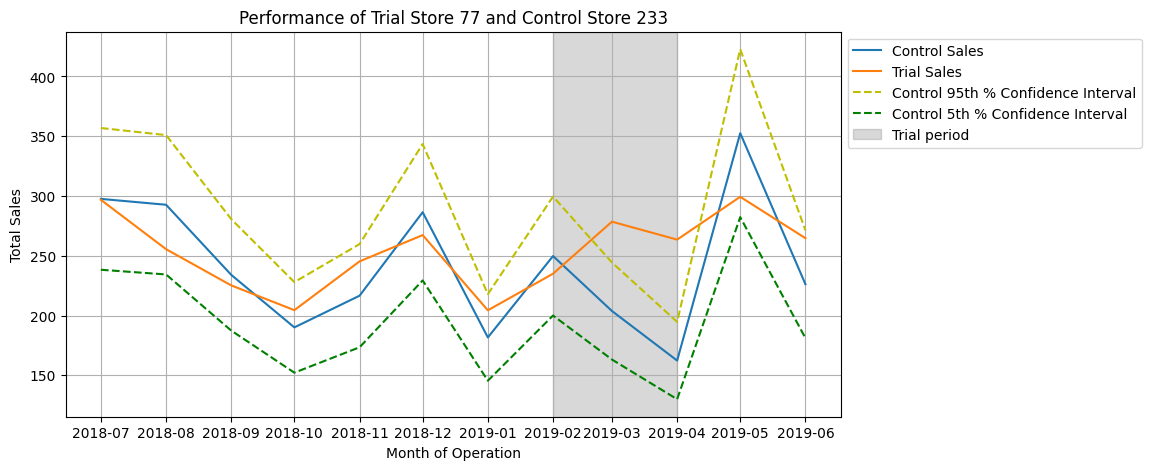

In [ ]:
plt.figure(figsize = (10,5))

# Convert MonthID to datetime format for x-axis
diff_full['MonthID'] = pd.to_datetime(diff_full['MonthID'], format='%Y%m')

# Plot the line graph of sales performance
plot_ctl = diff_full[(diff_full['Ctl_Store_NBR'] == control_store)][['MonthID', 'Ctl_Store_NBR', 'Control_Sales']]
plot_trial = diff_full[(diff_full['Trial_Store_NBR'] == trial_store)][['MonthID', 'Trial_Store_NBR', 'Trial_Sales']]

plt.plot(plot_ctl['MonthID'], plot_ctl['Control_Sales'], label='Control Sales')
plt.plot(plot_trial['MonthID'], plot_trial['Trial_Sales'], label='Trial Sales')

# plot the thresholds as lines
std_dev_pt = diff_pretrial['Sales_Percent_Diff'].std()
threshold95 = plot_ctl[['MonthID', 'Control_Sales']].copy()
threshold95['Control_Sales'] *= (1+std_dev_pt*2)
threshold5 = plot_ctl[['MonthID', 'Control_Sales']].copy()
threshold5['Control_Sales'] *= (1-std_dev_pt*2)

plt.plot(threshold95['MonthID'], threshold95['Control_Sales'], 'y--', label='Control 95th % Confidence Interval')
plt.plot(threshold5['MonthID'], threshold5['Control_Sales'], 'g--', label='Control 5th % Confidence Interval')

# Adding a shaded area to represent the trial period (February 2019 to April 2019)
plt.axvspan(pd.to_datetime('201902', format='%Y%m'), pd.to_datetime('201904', format='%Y%m'), color='gray', alpha=0.3, label='Trial period')

# Customize x-axis to show every month
months = pd.date_range(start='2018-07', #or lot_ctl['MonthID'].min()
                       end='2019-06',  #or lot_ctl['MonthID'].max()
                       freq='MS')  #frequence is Months
plt.xticks(months, [month.strftime('%Y-%m') for month in months], rotation=0)  # each tick mark corresponds to a month formatted as YYYY-MM

plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.title('Performance of Trial Store ' + str(trial_store) + ' and Control Store ' + str(control_store))
plt.grid(True)
plt.legend(loc = "upper left",bbox_to_anchor=(1, 1))
plt.show()

#### The results show that the trial in store 77 is significantly different to its control store (233) in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months.

## Assessment of Trial (Monthly Number of Customers)
This would be a repeat of the steps before for total sales:
- Scale pre-trial control customers to match pre-trial trial store customers.
- Compute a scaling factor to align control store customer counts to our trial store.
- Then, apply the scaling factor to control store customer counts.
- Finally, calculate the percentage difference between scaled control store customers and trial customers.

In [ ]:
## Scale pre-trial control customers to match pre-trial trial store customers (201807-201901)

# Filter data for trial store and control store before Feb 2019
trial_store_cust = pretrial_df[pretrial_df['STORE_NBR'] == trial_store].copy()
control_store_cust = pretrial_df[pretrial_df['STORE_NBR'] == control_store].copy()

# Calculate the number of customers for trial store and control store for the scaling factor
trial_store_ncust = trial_store_cust['nCustomers'].sum()
control_store_ncust = control_store_cust['nCustomers'].sum()
scalingF_control_ncust = trial_store_ncust / control_store_ncust

## Apply the scaling factor to the control store ncust in the dataset
control_store_cust.loc[:, 'Scaled_Ctl_nCustomers'] = control_store_cust.apply(
    lambda x: x['nCustomers'] * scalingF_control_ncust if x['STORE_NBR'] == control_store else '-', axis = 1)
control_store_cust

,STORE_NBR,MonthID,Monthly_Sales,nCustomers,Monthly_Trans,Total_Prod_Qty,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Store_Type,Scaled_Ctl_nCustomers
2699,233,201807,290.7,51,54,88,1.058824,1.629630,3.303409,Control,51.171141
2700,233,201808,285.9,48,50,80,1.041667,1.600000,3.573750,Control,48.161074
2701,233,201809,228.6,42,45,70,1.071429,1.555556,3.265714,Control,42.140940
2702,233,201810,185.7,35,36,56,1.028571,1.555556,3.316071,Control,35.117450
2703,233,201811,211.6,40,41,62,1.025000,1.512195,3.412903,Control,40.134228
2704,233,201812,279.8,47,50,75,1.063830,1.500000,3.730667,Control,47.157718
2705,233,201901,177.5,35,35,47,1.000000,1.342857,3.776596,Control,35.117450


In [ ]:
# Extract the columns we want, and calculate the percentage difference for pre-trial period
# Rename columns to avoid conflicts
trial_store_cust = trial_store_cust.rename(columns={'nCustomers':'Trial_nCust', 'STORE_NBR':'Trial_Store_NBR'})
control_store_cust = control_store_cust.rename(columns={'Scaled_Ctl_nCustomers':'Ctl_nCust', 'STORE_NBR':'Ctl_Store_NBR'})

# Merge the two data frames on 'MonthID'
diff_pretrial = pd.merge(trial_store_cust[['MonthID', 'Trial_nCust', 'Trial_Store_NBR']],
                         control_store_cust[['MonthID', 'Ctl_nCust', 'Ctl_Store_NBR']],
                         on='MonthID')

# Calculate the percentage difference
diff_pretrial['nCust_Percent_Diff'] = (diff_pretrial['Trial_nCust']-diff_pretrial['Ctl_nCust']) / diff_pretrial['Ctl_nCust'] #set control store's number of customers as baseline for comparing

diff_pretrial[['MonthID','Ctl_Store_NBR','Ctl_nCust','Trial_Store_NBR','Trial_nCust','nCust_Percent_Diff']]

,MonthID,Ctl_Store_NBR,Ctl_nCust,Trial_Store_NBR,Trial_nCust,nCust_Percent_Diff
0,201807,233,51.171141,77,51,-0.003344
1,201808,233,48.161074,77,47,-0.024108
2,201809,233,42.140940,77,42,-0.003344
3,201810,233,35.117450,77,37,0.053607
4,201811,233,40.134228,77,41,0.021572
5,201812,233,47.157718,77,46,-0.024550
6,201901,233,35.117450,77,35,-0.003344


In [ ]:
# Filter data for the trial period (201902-201904) for both trial and control stores
trial_store_cust_t = fullob_df[(fullob_df['STORE_NBR'] == trial_store)
                              & (fullob_df['MonthID'].astype(int) < 201905)
                              & (fullob_df['MonthID'].astype(int) > 201901)].copy()
control_store_cust_t = fullob_df[(fullob_df['STORE_NBR'] == control_store)
                                & (fullob_df['MonthID'].astype(int) < 201905)
                                & (fullob_df['MonthID'].astype(int) > 201901)].copy()

# Apply the scaling factor to the control store sales during trial period
control_store_cust_t['Scaled_Ctl_nCust'] = control_store_cust_t['nCustomers'] * scalingF_control_ncust

# Rename columns to avoid conflicts
trial_store_cust_t = trial_store_cust_t.rename(columns={'nCustomers':'Trial_nCust', 'STORE_NBR':'Trial_Store_NBR'})
control_store_cust_t = control_store_cust_t.rename(columns={'Scaled_Ctl_nCustomers':'Ctl_nCust', 'STORE_NBR':'Ctl_Store_NBR'})

# Merge the two data frames on 'MonthID'
diff_trial = pd.merge(trial_store_cust[['MonthID', 'Trial_nCust', 'Trial_Store_NBR']],
                      control_store_cust[['MonthID', 'Ctl_nCust', 'Ctl_Store_NBR']],
                      on='MonthID')

# Calculate the percentage difference
diff_trial['nCust_Percent_Diff'] = (diff_trial['Trial_nCust']-diff_trial['Ctl_nCust']) / diff_trial['Ctl_nCust'] #set control store's ncust as baseline for comparing

diff_trial[['MonthID','Ctl_Store_NBR','Ctl_nCust','Trial_Store_NBR','Trial_nCust','nCust_Percent_Diff']]

,MonthID,Ctl_Store_NBR,Ctl_nCust,Trial_Store_NBR,Trial_nCust,nCust_Percent_Diff
0,201807,233,51.171141,77,51,-0.003344
1,201808,233,48.161074,77,47,-0.024108
2,201809,233,42.140940,77,42,-0.003344
3,201810,233,35.117450,77,37,0.053607
4,201811,233,40.134228,77,41,0.021572
5,201812,233,47.157718,77,46,-0.024550
6,201901,233,35.117450,77,35,-0.003344


##### As our null hypothesis is that the trial period is the same as the pre-trial period, let's take the standard deviation based on the scaled percentage difference in the pre-trial period.
- Null Hypothesis (𝐻0): The trial period is no different from the pre-trial period.

- Alternative Hypothesis (𝐻1): The trial period is different from the pre-trial period.

Steps:
1. Calculate the Standard Deviation for Pre-Trial Period
2. Calculate the T-values for the Trial Months
3. Determine the Critical T-Value
4. Compare the T-Values
5. Visual Version of Comparison

In [ ]:
## Step1: Calculate the std for the pre-trial months (201807-201901)
std_dev_pt = diff_pretrial['nCust_Percent_Diff'].std()
print(f"Standard deviation for pre-trial period: {std_dev_pt:.4f}")

Standard deviation for pre-trial period: 0.0274


In [ ]:
## Step2: Calculate the T-values for the Trial Months (201902-201904)
# Population mean (null hypothesis)
mu = 0

# Calculate t-values
t_values = (diff_trial['nCust_Percent_Diff'] - mu) / std_dev_pt # Use the sample standard deviation for pre-trial period, which provides a benchmark to measure deviations during the trial period.

# Display t-values
diff_trial.loc[:,'T_Value'] = t_values
diff_trial

,MonthID,Trial_nCust,Trial_Store_NBR,Ctl_nCust,Ctl_Store_NBR,nCust_Percent_Diff,T_Value
0,201807,51,77,51.171141,233,-0.003344,-0.121884
1,201808,47,77,48.161074,233,-0.024108,-0.878578
2,201809,42,77,42.140940,233,-0.003344,-0.121884
3,201810,37,77,35.117450,233,0.053607,1.953620
4,201811,41,77,40.134228,233,0.021572,0.786149
5,201812,46,77,47.157718,233,-0.024550,-0.894678
6,201901,35,77,35.117450,233,-0.003344,-0.121884


In [ ]:
## Step3: Determine the Critical T-Value
# Degrees of freedom (df) ~ Pre-Trial Period
dof = len(diff_pretrial) - 1 # 7 months of data - 1
alpha = 0.05
t_critical = t.ppf(1 - alpha, dof)
print(f"Critical t-value for one-tailed test with df={dof}: {t_critical:.4f}")

Critical t-value for one-tailed test with df=6: 1.9432


#### 4. Compare the T-Values:
We can observe that the t-value in March and April is much larger than the critical t-value with 95% confidence interval.

It could be the increase in number of customers in the trial store in March and April is statistically greater than in the control store.

In [ ]:
## Step 5: Visual Version of Comparison
# Filter data for all months with full observation periods and see the whole trend. (201807-201906)
trial_store_cust_f = fullob_df[fullob_df['STORE_NBR'] == trial_store].copy()
control_store_cust_f = fullob_df[fullob_df['STORE_NBR'] == control_store].copy()

# Apply the scaling factor to the control store sales during trial period
control_store_cust_f['Scaled_Ctl_nCustomers'] = control_store_cust_f['nCustomers'] * scalingF_control_ncust

# Rename columns to avoid conflicts
trial_store_cust_f = trial_store_cust_f.rename(columns={'nCustomers':'Trial_nCust', 'STORE_NBR':'Trial_Store_NBR'})
control_store_cust_f = control_store_cust_f.rename(columns={'Scaled_Ctl_nCustomers':'Ctl_nCust', 'STORE_NBR':'Ctl_Store_NBR'})

# Merge the two data frames on 'MonthID'
diff_full = pd.merge(trial_store_cust_f[['MonthID', 'Trial_nCust', 'Trial_Store_NBR']],
                      control_store_cust_f[['MonthID', 'Ctl_nCust', 'Ctl_Store_NBR']],
                      on='MonthID')

# Calculate the percentage difference
diff_full['nCust_Percent_Diff'] = (diff_full['Trial_nCust']-diff_full['Ctl_nCust']) / diff_full['Ctl_nCust'] #set control store's ncust as baseline for comparing

diff_full[['MonthID','Ctl_Store_NBR','Ctl_nCust','Trial_Store_NBR','Trial_nCust','nCust_Percent_Diff']]

,MonthID,Ctl_Store_NBR,Ctl_nCust,Trial_Store_NBR,Trial_nCust,nCust_Percent_Diff
0,201807,233,51.171141,77,51,-0.003344
1,201808,233,48.161074,77,47,-0.024108
2,201809,233,42.140940,77,42,-0.003344
3,201810,233,35.117450,77,37,0.053607
4,201811,233,40.134228,77,41,0.021572
5,201812,233,47.157718,77,46,-0.024550
6,201901,233,35.117450,77,35,-0.003344
7,201902,233,45.151007,77,45,-0.003344
8,201903,233,40.134228,77,50,0.245819
9,201904,233,30.100671,77,47,0.561427


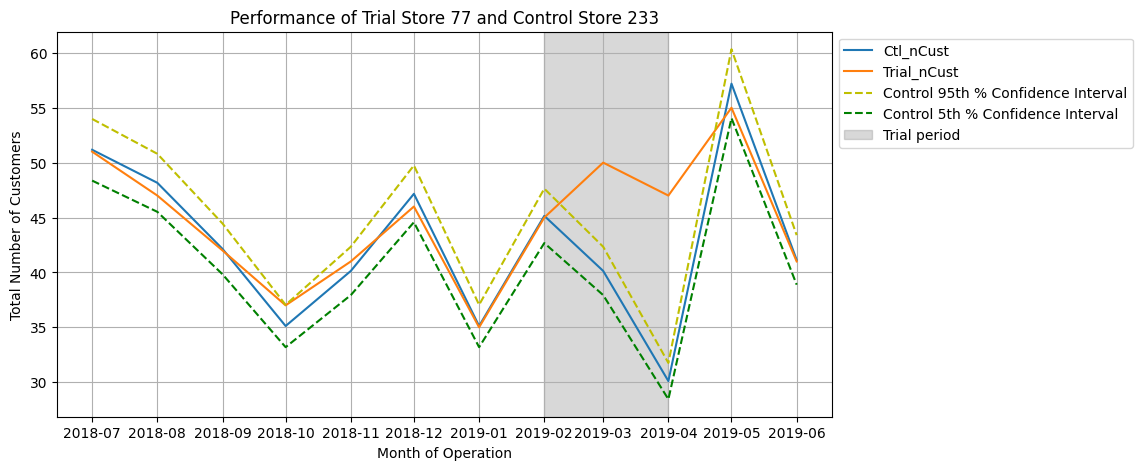

In [ ]:
plt.figure(figsize = (10,5))

# Convert MonthID to datetime format for x-axis
diff_full['MonthID'] = pd.to_datetime(diff_full['MonthID'], format='%Y%m')

# Plot the line graph of sales performance
plot_ctl = diff_full[(diff_full['Ctl_Store_NBR'] == control_store)][['MonthID', 'Ctl_Store_NBR', 'Ctl_nCust']]
plot_trial = diff_full[(diff_full['Trial_Store_NBR'] == trial_store)][['MonthID', 'Trial_Store_NBR', 'Trial_nCust']]

plt.plot(plot_ctl['MonthID'], plot_ctl['Ctl_nCust'], label='Ctl_nCust')
plt.plot(plot_trial['MonthID'], plot_trial['Trial_nCust'], label='Trial_nCust')

# plot the thresholds as lines
std_dev_pt = diff_pretrial['nCust_Percent_Diff'].std()
threshold95 = plot_ctl[['MonthID', 'Ctl_nCust']].copy()
threshold95['Ctl_nCust'] *= (1+std_dev_pt*2)
threshold5 = plot_ctl[['MonthID', 'Ctl_nCust']].copy()
threshold5['Ctl_nCust'] *= (1-std_dev_pt*2)

plt.plot(threshold95['MonthID'], threshold95['Ctl_nCust'], 'y--', label='Control 95th % Confidence Interval')
plt.plot(threshold5['MonthID'], threshold5['Ctl_nCust'], 'g--', label='Control 5th % Confidence Interval')

# Adding a shaded area to represent the trial period (February 2019 to April 2019)
plt.axvspan(pd.to_datetime('201902', format='%Y%m'), pd.to_datetime('201904', format='%Y%m'), color='gray', alpha=0.3, label='Trial period')

# Customize x-axis to show every month
months = pd.date_range(start='2018-07', #or lot_ctl['MonthID'].min()
                       end='2019-06',  #or lot_ctl['MonthID'].max()
                       freq='MS')  #frequence is Months
plt.xticks(months, [month.strftime('%Y-%m') for month in months], rotation=0)  # each tick mark corresponds to a month formatted as YYYY-MM

plt.xlabel('Month of Operation')
plt.ylabel('Total Number of Customers')
plt.title('Performance of Trial Store ' + str(trial_store) + ' and Control Store ' + str(control_store))
plt.grid(True)
plt.legend(loc = "upper left",bbox_to_anchor=(1, 1))
plt.show()

#### The results show that the trial in store 77 is significantly different to its control store (233) in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months.

# Trial store 86

In [ ]:
trial_store = 86

### Use functions to calculate metrics

In [ ]:
# calculate correlations of monthly total sales & number of customers against store
corr_nSales = calc_correlation(pretrial_df,'Monthly_Sales',trial_store)
corr_nCust = calc_correlation(pretrial_df,'nCustomers',trial_store)

# calculating magnitude distance of monthly total sales against store
magnitude_nSales = calc_magnitude_distance(pretrial_df,'Monthly_Sales',trial_store)
magnitude_nCust = calc_magnitude_distance(pretrial_df,'nCustomers',trial_store)

### Create a combined score composed of correlation and magnitude.


In [ ]:
corr_weight = 0.5

# first merging the correlations table with the magnitude table.
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on = ['Store1', 'Store2'])
score_nCust = pd.merge(corr_nCust, magnitude_nCust, on = ['Store1', 'Store2'])

score_nSales['scoreNSales'] = corr_weight * score_nSales['Corr_Measure'] + (1 - corr_weight) * score_nSales['MagnitudeMeasure']
score_nCust['scoreNCust'] = corr_weight * score_nCust['Corr_Measure'] + (1 - corr_weight) * score_nCust['MagnitudeMeasure']

##### Now we have a score for each of total number of sales and number of customers. Let’s combine the two via a simple average.

In [ ]:
# merge the sales scores and customer scores into a single table
score_control = pd.merge(score_nSales, score_nCust, on = ['Store1', 'Store2'], suffixes = ('_Sales', '_Cust'))
score_control['Final_Control_Score'] = score_control['scoreNSales']*0.5 + score_control['scoreNCust']*0.5
score_control.head()

,Store1,Store2,Corr_Measure_Sales,MagnitudeMeasure_Sales,scoreNSales,Corr_Measure_Cust,MagnitudeMeasure_Cust,scoreNCust,Final_Control_Score
0,86,1,0.445632,0.220565,0.333099,0.485831,0.444597,0.465214,0.399156
1,86,2,-0.403835,0.179640,-0.112097,-0.086161,0.38062,0.14723,0.017566
2,86,3,-0.261284,0.762894,0.250805,-0.353786,0.91185,0.279032,0.264919
3,86,4,-0.039035,0.498526,0.229745,-0.169608,0.773922,0.302157,0.265951
4,86,5,0.235159,0.929321,0.582240,-0.253229,0.926509,0.33664,0.45944


##### The store with the highest score is then selected as the control store since it is most similar to the trial store.

In [ ]:
score_control = score_control.sort_values(by = 'Final_Control_Score', ascending = False).head()
score_control

,Store1,Store2,Corr_Measure_Sales,MagnitudeMeasure_Sales,scoreNSales,Corr_Measure_Cust,MagnitudeMeasure_Cust,scoreNCust,Final_Control_Score
146,86,155,0.877882,0.964782,0.921332,0.942876,0.985037,0.963956,0.942644
101,86,109,0.788300,0.963810,0.876055,0.770778,0.96594,0.868359,0.872207
106,86,114,0.734415,0.921021,0.827718,0.855339,0.935508,0.895424,0.861571
129,86,138,0.759864,0.925434,0.842649,0.749701,0.928031,0.838866,0.840757
212,86,225,0.617533,0.958060,0.787796,0.733791,0.967367,0.850579,0.819188


#### Summary: Store 155 is the most appropriate control store for store 86, because it has the highest final control score.

##### Now that we have found a control store, let’s check visually if the drivers are indeed similar in the pre-trial period.

### Visual checks on trends based on the drivers

In [ ]:
# define trial store and control tore pair
trial_store = 86
control_store = 155

In [ ]:
# Define store type and visualize
fullob_df = fullob_df.copy()
pretrial_df = pretrial_df.copy()

fullob_df['Store_Type'] = fullob_df['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other Stores'))

pretrial_df['Store_Type'] = pretrial_df['STORE_NBR'].apply(
        lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other Stores'))

In [ ]:
# Calculate total sales mean by MonthID and Store_type
past_sales = pretrial_df.groupby(['MonthID', 'Store_Type'])['Monthly_Sales'].mean().reset_index()

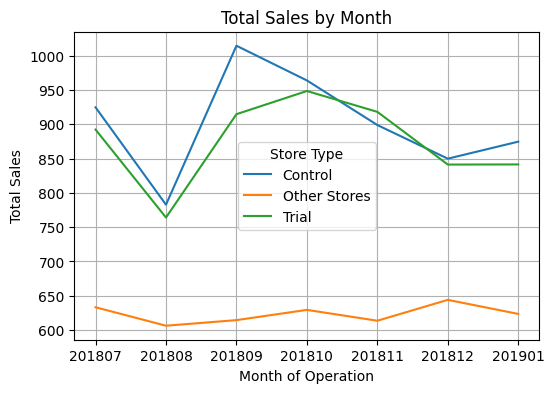

In [ ]:
plt.figure(figsize=(6, 4))
for store_type, group in past_sales.groupby('Store_Type'):  #define 'group' will be a DataFrame that contains all rows in the same store types(3 types here)
    plt.plot(group['MonthID'], group['Monthly_Sales'], label=store_type) #point the x-axis data, y-asix data and lable for the plot.
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.title('Total Sales by Month')
plt.legend(title='Store Type')
plt.grid(True)
plt.show()

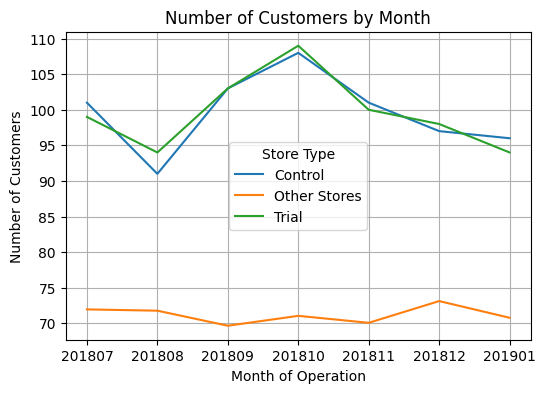

In [ ]:
# Visual checks on trends based on the drivers (number of customers)

# Calculate number of customers mean by MonthID and Store_type
past_cust = pretrial_df.groupby(['MonthID', 'Store_Type'])['nCustomers'].mean().reset_index()

# plot the result
plt.figure(figsize=(6, 4))
for store_type, group in past_cust.groupby('Store_Type'):
    plt.plot(group['MonthID'], group['nCustomers'], label=store_type)

plt.xlabel('Month of Operation')
plt.ylabel('Number of Customers')
plt.title('Number of Customers by Month')
plt.legend(title='Store Type')
plt.grid(True)
plt.show()

#### Summary: From the graphs, for trial & control store pair 86-155, sales and number of customers are trending in a similar way.

## Assessment of Trial (Monthly Total Sales)
The trial period goes from the start of February 2019 to April 2019. We now want to see if there has been an uplift in overall chip sales.

Start with scaling the control store's sales to a level similar to control
for any differences between the two stores outside of the trial period.

In [ ]:
## Scale pre-trial control sales to match pre-trial trial store sales （201807-201901）
#measure_overtime_sales only include full observation data during pre-trial period

# Filter data for trial store and control store for pre-trial period
trial_store_sales = pretrial_df[(pretrial_df['STORE_NBR'] == trial_store)].copy()
control_store_sales = pretrial_df[(pretrial_df['STORE_NBR'] == control_store)].copy()

# Calculate the total sales for trial store and control store for the scaling factor
trial_store_totsales = trial_store_sales['Monthly_Sales'].sum()
control_store_totsales = control_store_sales['Monthly_Sales'].sum()
scalingF_control_sales = trial_store_totsales / control_store_totsales

# Apply the scaling factor to the control store sales in the dataset
control_store_sales['Scaled_Ctl_Sales'] = control_store_sales.apply(
    lambda x: x['Monthly_Sales'] * scalingF_control_sales if x['STORE_NBR'] == control_store else '-', axis=1)
control_store_sales

,STORE_NBR,MonthID,Monthly_Sales,nCustomers,Monthly_Trans,Total_Prod_Qty,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Store_Type,Scaled_Ctl_Sales
1793,155,201807,924.6,101,123,250,1.217822,2.032520,3.698400,Control,896.922236
1794,155,201808,782.7,91,119,229,1.307692,1.924370,3.417904,Control,759.269991
1795,155,201809,1014.4,103,144,290,1.398058,2.013889,3.497931,Control,984.034086
1796,155,201810,963.8,108,136,272,1.259259,2.000000,3.543382,Control,934.948790
1797,155,201811,898.8,101,133,270,1.316832,2.030075,3.328889,Control,871.894555
1798,155,201812,849.8,97,120,242,1.237113,2.016667,3.511570,Control,824.361363
1799,155,201901,874.6,96,125,252,1.302083,2.016000,3.470635,Control,848.418979


In [ ]:
# Extract the columns we want, and calculate the percentage difference for pre-trial period
# Rename columns to avoid conflicts
trial_store_sales = trial_store_sales.rename(columns={'Monthly_Sales':'Trial_Sales', 'STORE_NBR':'Trial_Store_NBR'})
control_store_sales = control_store_sales.rename(columns={'Scaled_Ctl_Sales':'Control_Sales', 'STORE_NBR':'Ctl_Store_NBR'})

# Merge the two data frames on 'MonthID'
diff_pretrial = pd.merge(trial_store_sales[['MonthID', 'Trial_Sales', 'Trial_Store_NBR']],
                   control_store_sales[['MonthID', 'Control_Sales', 'Ctl_Store_NBR']],
                   on='MonthID')

# Calculate the percentage difference
diff_pretrial['Sales_Percent_Diff'] = (diff_pretrial['Trial_Sales']-diff_pretrial['Control_Sales']) / diff_pretrial['Control_Sales'] #set control store'sales as baseline for comparing

diff_pretrial[['MonthID','Ctl_Store_NBR','Control_Sales','Trial_Store_NBR','Trial_Sales','Sales_Percent_Diff']]

,MonthID,Ctl_Store_NBR,Control_Sales,Trial_Store_NBR,Trial_Sales,Sales_Percent_Diff
0,201807,155,896.922236,86,892.20,-0.005265
1,201808,155,759.269991,86,764.05,0.006296
2,201809,155,984.034086,86,914.60,-0.070561
3,201810,155,934.948790,86,948.40,0.014387
4,201811,155,871.894555,86,918.00,0.052880
5,201812,155,824.361363,86,841.20,0.020426
6,201901,155,848.418979,86,841.40,-0.008273


##### Now that we have comparable sales figures for the control store, we can calculate the percentage difference between the scaled control sales and the trial store's sales during the trial period(201902-201904).

In [ ]:
# Filter data for the trial period (201902-201904) for both trial and control stores
trial_store_sales_t = fullob_df[(fullob_df['STORE_NBR'] == trial_store)
                              & (fullob_df['MonthID'].astype(int) < 201905)
                              & (fullob_df['MonthID'].astype(int) > 201901)].copy()
control_store_sales_t = fullob_df[(fullob_df['STORE_NBR'] == control_store)
                                & (fullob_df['MonthID'].astype(int) < 201905)
                                & (fullob_df['MonthID'].astype(int) > 201901)].copy()

# Apply the scaling factor to the control store sales during trial period
control_store_sales_t['Scaled_Ctl_Sales'] = control_store_sales_t['Monthly_Sales'] * scalingF_control_sales

In [ ]:
# Rename columns to avoid conflicts
trial_store_sales_t = trial_store_sales_t.rename(columns={'Monthly_Sales':'Trial_Sales', 'STORE_NBR':'Trial_Store_NBR'})
control_store_sales_t = control_store_sales_t.rename(columns={'Scaled_Ctl_Sales':'Control_Sales', 'STORE_NBR':'Ctl_Store_NBR'})

# Merge the two data frames on 'MonthID'
diff_trial = pd.merge(trial_store_sales_t[['MonthID', 'Trial_Sales', 'Trial_Store_NBR']],
                   control_store_sales_t[['MonthID', 'Control_Sales', 'Ctl_Store_NBR']],
                   on='MonthID')

# Calculate the percentage difference
diff_trial['Sales_Percent_Diff'] = (diff_trial['Trial_Sales']-diff_trial['Control_Sales']) / diff_trial['Control_Sales'] #set control store'sales as baseline for comparing

diff_trial[['MonthID','Ctl_Store_NBR','Control_Sales','Trial_Store_NBR','Trial_Sales','Sales_Percent_Diff']].head()

,MonthID,Ctl_Store_NBR,Control_Sales,Trial_Store_NBR,Trial_Sales,Sales_Percent_Diff
0,201902,155,864.522060,86,913.2,0.056306
1,201903,155,780.320405,86,1026.8,0.315870
2,201904,155,819.317024,86,848.2,0.035253


##### As our null hypothesis is that the trial period is the same as the pre-trial period, let's take the standard deviation based on the scaled percentage difference in the pre-trial period.
- Null Hypothesis (𝐻0): The trial period is no different from the pre-trial period.

- Alternative Hypothesis (𝐻1): The trial period is different from the pre-trial period.

#### 1. Calculate the Standard Deviation for Pre-Trial Period:

In [ ]:
std_dev_pt = diff_pretrial['Sales_Percent_Diff'].std()
print(f"Standard deviation for pre-trial period: {std_dev_pt:.4f}")

Standard deviation for pre-trial period: 0.0377


#### 2. Calculate the T-values for the Trial Months:

In [ ]:
# Population mean (null hypothesis)
mu = 0

# Calculate t-values
t_values = (diff_trial['Sales_Percent_Diff'] - mu) / std_dev_pt # Use the sample standard deviation for pre-trial period, which provides a benchmark to measure deviations during the trial period.

# Display t-values
diff_trial.loc[:,'T_Value'] = t_values
diff_trial

,MonthID,Trial_Sales,Trial_Store_NBR,Control_Sales,Ctl_Store_NBR,Sales_Percent_Diff,T_Value
0,201902,913.2,86,864.522060,155,0.056306,1.494114
1,201903,1026.8,86,780.320405,155,0.315870,8.381769
2,201904,848.2,86,819.317024,155,0.035253,0.935444


#### 3. Determine the Critical T-Value:

In [ ]:
# Degrees of freedom (df) ~ Pre-Trial Period
dof = len(diff_pretrial) - 1 # 7 months of data - 1

# Two-tailed test: significance level = 0.05
alpha = 0.05
t_critical = t.ppf(1 - alpha, dof)
print(f"Critical t-value for one-tailed test with df={dof}: {t_critical:.4f}")

Critical t-value for one-tailed test with df=6: 1.9432


#### 4. Compare the T-Values:
We can observe that the t-value in March is much larger than the critical t-value with 95% confidence interval. It could be the increase in sales in the trial store in March is statistically greater than in the control store.

#### 5. Visual Version of Comparison:
Let's create a more visual version of this by plotting the sales of the control store, the sales of the trial stores and the 95th percentile value of sales of the control store.

In [ ]:
## Method2: Filter data for all months with full observation periods and see the whole trend. (201807-201906)
trial_store_sales_f = fullob_df[fullob_df['STORE_NBR'] == trial_store].copy()
control_store_sales_f = fullob_df[fullob_df['STORE_NBR'] == control_store].copy()

# Apply the scaling factor to the control store sales during trial period
control_store_sales_f['Scaled_Ctl_Sales'] = control_store_sales_f['Monthly_Sales'] * scalingF_control_sales

# Rename columns to avoid conflicts
trial_store_sales_f = trial_store_sales_f.rename(columns={'Monthly_Sales':'Trial_Sales', 'STORE_NBR':'Trial_Store_NBR'})
control_store_sales_f = control_store_sales_f.rename(columns={'Scaled_Ctl_Sales':'Control_Sales', 'STORE_NBR':'Ctl_Store_NBR'})

# Merge the two data frames on 'MonthID'
diff_full = pd.merge(trial_store_sales_f[['MonthID', 'Trial_Sales', 'Trial_Store_NBR']],
                   control_store_sales_f[['MonthID', 'Control_Sales', 'Ctl_Store_NBR']],
                   on='MonthID')

# Calculate the percentage difference
diff_full['Percent_Diff'] = (diff_full['Trial_Sales']-diff_full['Control_Sales']) / diff_full['Control_Sales'] #set control store'sales as baseline for comparing

diff_full[['MonthID','Ctl_Store_NBR','Control_Sales','Trial_Store_NBR','Trial_Sales','Percent_Diff']]

,MonthID,Ctl_Store_NBR,Control_Sales,Trial_Store_NBR,Trial_Sales,Percent_Diff
0,201807,155,896.922236,86,892.20,-0.005265
1,201808,155,759.269991,86,764.05,0.006296
2,201809,155,984.034086,86,914.60,-0.070561
3,201810,155,934.948790,86,948.40,0.014387
4,201811,155,871.894555,86,918.00,0.052880
5,201812,155,824.361363,86,841.20,0.020426
6,201901,155,848.418979,86,841.40,-0.008273
7,201902,155,864.522060,86,913.20,0.056306
8,201903,155,780.320405,86,1026.80,0.315870
9,201904,155,819.317024,86,848.20,0.035253


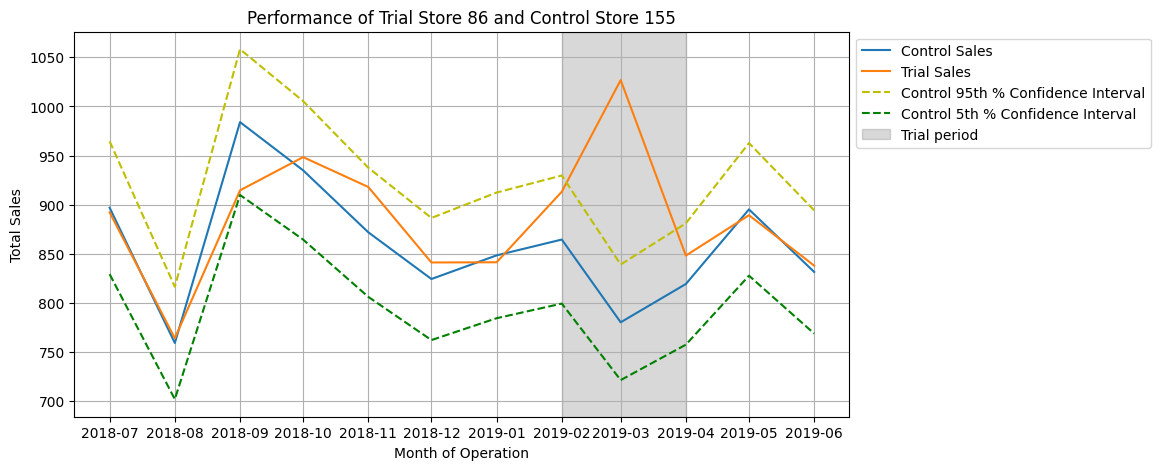

In [ ]:
plt.figure(figsize = (10,5))

# Convert MonthID to datetime format for x-axis
diff_full['MonthID'] = pd.to_datetime(diff_full['MonthID'], format='%Y%m')

# Plot the line graph of sales performance
plot_ctl = diff_full[(diff_full['Ctl_Store_NBR'] == control_store)][['MonthID', 'Ctl_Store_NBR', 'Control_Sales']]
plot_trial = diff_full[(diff_full['Trial_Store_NBR'] == trial_store)][['MonthID', 'Trial_Store_NBR', 'Trial_Sales']]

plt.plot(plot_ctl['MonthID'], plot_ctl['Control_Sales'], label='Control Sales')
plt.plot(plot_trial['MonthID'], plot_trial['Trial_Sales'], label='Trial Sales')

# plot the thresholds as lines
std_dev_pt = diff_pretrial['Sales_Percent_Diff'].std()
threshold95 = plot_ctl[['MonthID', 'Control_Sales']].copy()
threshold95['Control_Sales'] *= (1+std_dev_pt*2)
threshold5 = plot_ctl[['MonthID', 'Control_Sales']].copy()
threshold5['Control_Sales'] *= (1-std_dev_pt*2)

plt.plot(threshold95['MonthID'], threshold95['Control_Sales'], 'y--', label='Control 95th % Confidence Interval')
plt.plot(threshold5['MonthID'], threshold5['Control_Sales'], 'g--', label='Control 5th % Confidence Interval')

# Adding a shaded area to represent the trial period (February 2019 to April 2019)
plt.axvspan(pd.to_datetime('201902', format='%Y%m'), pd.to_datetime('201904', format='%Y%m'), color='gray', alpha=0.3, label='Trial period')

# Customize x-axis to show every month
months = pd.date_range(start='2018-07', #or lot_ctl['MonthID'].min()
                       end='2019-06',  #or lot_ctl['MonthID'].max()
                       freq='MS')  #frequence is Months
plt.xticks(months, [month.strftime('%Y-%m') for month in months], rotation=0)  # each tick mark corresponds to a month formatted as YYYY-MM

plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.title('Performance of Trial Store ' + str(trial_store) + ' and Control Store ' + str(control_store))
plt.grid(True)
plt.legend(loc = "upper left",bbox_to_anchor=(1, 1))
plt.show()

#### The results show that the trial in store 86 is not significantly different to its control store in the trial period as the trial store performance lies inside the 5% to 95% confidence interval of the control store in two of the three trial months.

## Assessment of Trial (Monthly Number of Customers)
This would be a repeat of the steps before for total sales:
- Scale pre-trial control customers to match pre-trial trial store customers.
- Compute a scaling factor to align control store customer counts to our trial store.
- Then, apply the scaling factor to control store customer counts.
- Finally, calculate the percentage difference between scaled control store customers and trial customers.

In [ ]:
## Scale pre-trial control customers to match pre-trial trial store customers (201807-201901)

# Filter data for trial store and control store before Feb 2019
trial_store_cust = pretrial_df[pretrial_df['STORE_NBR'] == trial_store].copy()
control_store_cust = pretrial_df[pretrial_df['STORE_NBR'] == control_store].copy()

# Calculate the number of customers for trial store and control store for the scaling factor
trial_store_ncust = trial_store_cust['nCustomers'].sum()
control_store_ncust = control_store_cust['nCustomers'].sum()
scalingF_control_ncust = trial_store_ncust / control_store_ncust

## Apply the scaling factor to the control store ncust in the dataset
control_store_cust.loc[:, 'Scaled_Ctl_nCustomers'] = control_store_cust.apply(
    lambda x: x['nCustomers'] * scalingF_control_ncust if x['STORE_NBR'] == control_store else '-', axis = 1)
control_store_cust

,STORE_NBR,MonthID,Monthly_Sales,nCustomers,Monthly_Trans,Total_Prod_Qty,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Store_Type,Scaled_Ctl_nCustomers
1793,155,201807,924.6,101,123,250,1.217822,2.032520,3.698400,Control,101.0
1794,155,201808,782.7,91,119,229,1.307692,1.924370,3.417904,Control,91.0
1795,155,201809,1014.4,103,144,290,1.398058,2.013889,3.497931,Control,103.0
1796,155,201810,963.8,108,136,272,1.259259,2.000000,3.543382,Control,108.0
1797,155,201811,898.8,101,133,270,1.316832,2.030075,3.328889,Control,101.0
1798,155,201812,849.8,97,120,242,1.237113,2.016667,3.511570,Control,97.0
1799,155,201901,874.6,96,125,252,1.302083,2.016000,3.470635,Control,96.0


In [ ]:
# Extract the columns we want, and calculate the percentage difference for pre-trial period
# Rename columns to avoid conflicts
trial_store_cust = trial_store_cust.rename(columns={'nCustomers':'Trial_nCust', 'STORE_NBR':'Trial_Store_NBR'})
control_store_cust = control_store_cust.rename(columns={'Scaled_Ctl_nCustomers':'Ctl_nCust', 'STORE_NBR':'Ctl_Store_NBR'})

# Merge the two data frames on 'MonthID'
diff_pretrial = pd.merge(trial_store_cust[['MonthID', 'Trial_nCust', 'Trial_Store_NBR']],
                         control_store_cust[['MonthID', 'Ctl_nCust', 'Ctl_Store_NBR']],
                         on='MonthID')

# Calculate the percentage difference
diff_pretrial['nCust_Percent_Diff'] = (diff_pretrial['Trial_nCust']-diff_pretrial['Ctl_nCust']) / diff_pretrial['Ctl_nCust'] #set control store's number of customers as baseline for comparing

diff_pretrial[['MonthID','Ctl_Store_NBR','Ctl_nCust','Trial_Store_NBR','Trial_nCust','nCust_Percent_Diff']]

,MonthID,Ctl_Store_NBR,Ctl_nCust,Trial_Store_NBR,Trial_nCust,nCust_Percent_Diff
0,201807,155,101.0,86,99,-0.019802
1,201808,155,91.0,86,94,0.032967
2,201809,155,103.0,86,103,0.000000
3,201810,155,108.0,86,109,0.009259
4,201811,155,101.0,86,100,-0.009901
5,201812,155,97.0,86,98,0.010309
6,201901,155,96.0,86,94,-0.020833


In [ ]:
# Filter data for the trial period (201902-201904) for both trial and control stores
trial_store_cust_t = fullob_df[(fullob_df['STORE_NBR'] == trial_store)
                              & (fullob_df['MonthID'].astype(int) < 201905)
                              & (fullob_df['MonthID'].astype(int) > 201901)].copy()
control_store_cust_t = fullob_df[(fullob_df['STORE_NBR'] == control_store)
                                & (fullob_df['MonthID'].astype(int) < 201905)
                                & (fullob_df['MonthID'].astype(int) > 201901)].copy()

# Apply the scaling factor to the control store sales during trial period
control_store_cust_t['Scaled_Ctl_nCust'] = control_store_cust_t['nCustomers'] * scalingF_control_ncust

# Rename columns to avoid conflicts
trial_store_cust_t = trial_store_cust_t.rename(columns={'nCustomers':'Trial_nCust', 'STORE_NBR':'Trial_Store_NBR'})
control_store_cust_t = control_store_cust_t.rename(columns={'Scaled_Ctl_nCustomers':'Ctl_nCust', 'STORE_NBR':'Ctl_Store_NBR'})

# Merge the two data frames on 'MonthID'
diff_trial = pd.merge(trial_store_cust[['MonthID', 'Trial_nCust', 'Trial_Store_NBR']],
                      control_store_cust[['MonthID', 'Ctl_nCust', 'Ctl_Store_NBR']],
                      on='MonthID')

# Calculate the percentage difference
diff_trial['nCust_Percent_Diff'] = (diff_trial['Trial_nCust']-diff_trial['Ctl_nCust']) / diff_trial['Ctl_nCust'] #set control store's ncust as baseline for comparing

diff_trial[['MonthID','Ctl_Store_NBR','Ctl_nCust','Trial_Store_NBR','Trial_nCust','nCust_Percent_Diff']]

,MonthID,Ctl_Store_NBR,Ctl_nCust,Trial_Store_NBR,Trial_nCust,nCust_Percent_Diff
0,201807,155,101.0,86,99,-0.019802
1,201808,155,91.0,86,94,0.032967
2,201809,155,103.0,86,103,0.000000
3,201810,155,108.0,86,109,0.009259
4,201811,155,101.0,86,100,-0.009901
5,201812,155,97.0,86,98,0.010309
6,201901,155,96.0,86,94,-0.020833


##### As our null hypothesis is that the trial period is the same as the pre-trial period, let's take the standard deviation based on the scaled percentage difference in the pre-trial period.
- Null Hypothesis (𝐻0): The trial period is no different from the pre-trial period.

- Alternative Hypothesis (𝐻1): The trial period is different from the pre-trial period.

Steps:
1. Calculate the Standard Deviation for Pre-Trial Period
2. Calculate the T-values for the Trial Months
3. Determine the Critical T-Value
4. Compare the T-Values
5. Visual Version of Comparison

In [ ]:
## Step1: Calculate the std for the pre-trial months (201807-201901)
std_dev_pt = diff_pretrial['nCust_Percent_Diff'].std()
print(f"Standard deviation for pre-trial period: {std_dev_pt:.4f}")

Standard deviation for pre-trial period: 0.0192


In [ ]:
## Step2: Calculate the T-values for the Trial Months (201902-201904)
# Population mean (null hypothesis)
mu = 0

# Calculate t-values
t_values = (diff_trial['nCust_Percent_Diff'] - mu) / std_dev_pt # Use the sample standard deviation for pre-trial period, which provides a benchmark to measure deviations during the trial period.

# Display t-values
diff_trial.loc[:,'T_Value'] = t_values
diff_trial

,MonthID,Trial_nCust,Trial_Store_NBR,Ctl_nCust,Ctl_Store_NBR,nCust_Percent_Diff,T_Value
0,201807,99,86,101.0,155,-0.019802,-1.033550
1,201808,94,86,91.0,155,0.032967,1.720691
2,201809,103,86,103.0,155,0.000000,0.000000
3,201810,109,86,108.0,155,0.009259,0.483281
4,201811,100,86,101.0,155,-0.009901,-0.516775
5,201812,98,86,97.0,155,0.010309,0.538086
6,201901,94,86,96.0,155,-0.020833,-1.087381


In [ ]:
## Step3: Determine the Critical T-Value
# Degrees of freedom (df) ~ Pre-Trial Period
dof = len(diff_pretrial) - 1 # 7 months of data - 1
alpha = 0.05
t_critical = t.ppf(1 - alpha, dof)
print(f"Critical t-value for one-tailed test with df={dof}: {t_critical:.4f}")

Critical t-value for one-tailed test with df=6: 1.9432


#### 4. Compare the T-Values:
We can observe that the t-value in March and April is much larger than the critical t-value with 95% confidence interval.

It could be the increase in number of customers in the trial store in March and April is statistically greater than in the control store.

In [ ]:
## Step 5: Visual Version of Comparison
# Filter data for all months with full observation periods and see the whole trend. (201807-201906)
trial_store_cust_f = fullob_df[fullob_df['STORE_NBR'] == trial_store].copy()
control_store_cust_f = fullob_df[fullob_df['STORE_NBR'] == control_store].copy()

# Apply the scaling factor to the control store sales during trial period
control_store_cust_f['Scaled_Ctl_nCustomers'] = control_store_cust_f['nCustomers'] * scalingF_control_ncust

# Rename columns to avoid conflicts
trial_store_cust_f = trial_store_cust_f.rename(columns={'nCustomers':'Trial_nCust', 'STORE_NBR':'Trial_Store_NBR'})
control_store_cust_f = control_store_cust_f.rename(columns={'Scaled_Ctl_nCustomers':'Ctl_nCust', 'STORE_NBR':'Ctl_Store_NBR'})

# Merge the two data frames on 'MonthID'
diff_full = pd.merge(trial_store_cust_f[['MonthID', 'Trial_nCust', 'Trial_Store_NBR']],
                      control_store_cust_f[['MonthID', 'Ctl_nCust', 'Ctl_Store_NBR']],
                      on='MonthID')

# Calculate the percentage difference
diff_full['nCust_Percent_Diff'] = (diff_full['Trial_nCust']-diff_full['Ctl_nCust']) / diff_full['Ctl_nCust'] #set control store's ncust as baseline for comparing

diff_full[['MonthID','Ctl_Store_NBR','Ctl_nCust','Trial_Store_NBR','Trial_nCust','nCust_Percent_Diff']]

,MonthID,Ctl_Store_NBR,Ctl_nCust,Trial_Store_NBR,Trial_nCust,nCust_Percent_Diff
0,201807,155,101.0,86,99,-0.019802
1,201808,155,91.0,86,94,0.032967
2,201809,155,103.0,86,103,0.000000
3,201810,155,108.0,86,109,0.009259
4,201811,155,101.0,86,100,-0.009901
5,201812,155,97.0,86,98,0.010309
6,201901,155,96.0,86,94,-0.020833
7,201902,155,95.0,86,107,0.126316
8,201903,155,94.0,86,115,0.223404
9,201904,155,99.0,86,105,0.060606


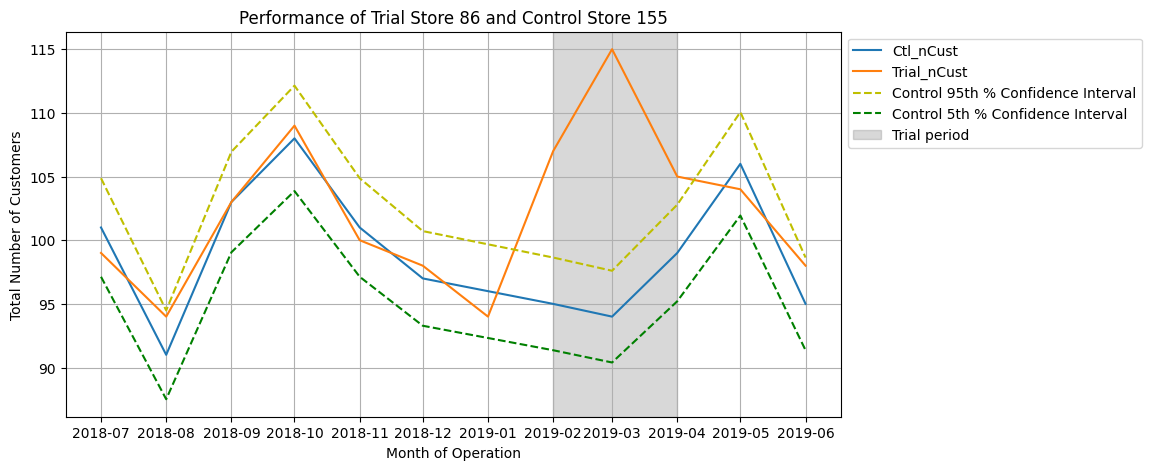

In [ ]:
plt.figure(figsize = (10,5))

# Convert MonthID to datetime format for x-axis
diff_full['MonthID'] = pd.to_datetime(diff_full['MonthID'], format='%Y%m')

# Plot the line graph of sales performance
plot_ctl = diff_full[(diff_full['Ctl_Store_NBR'] == control_store)][['MonthID', 'Ctl_Store_NBR', 'Ctl_nCust']]
plot_trial = diff_full[(diff_full['Trial_Store_NBR'] == trial_store)][['MonthID', 'Trial_Store_NBR', 'Trial_nCust']]

plt.plot(plot_ctl['MonthID'], plot_ctl['Ctl_nCust'], label='Ctl_nCust')
plt.plot(plot_trial['MonthID'], plot_trial['Trial_nCust'], label='Trial_nCust')

# plot the thresholds as lines
std_dev_pt = diff_pretrial['nCust_Percent_Diff'].std()
threshold95 = plot_ctl[['MonthID', 'Ctl_nCust']].copy()
threshold95['Ctl_nCust'] *= (1+std_dev_pt*2)
threshold5 = plot_ctl[['MonthID', 'Ctl_nCust']].copy()
threshold5['Ctl_nCust'] *= (1-std_dev_pt*2)

plt.plot(threshold95['MonthID'], threshold95['Ctl_nCust'], 'y--', label='Control 95th % Confidence Interval')
plt.plot(threshold5['MonthID'], threshold5['Ctl_nCust'], 'g--', label='Control 5th % Confidence Interval')

# Adding a shaded area to represent the trial period (February 2019 to April 2019)
plt.axvspan(pd.to_datetime('201902', format='%Y%m'), pd.to_datetime('201904', format='%Y%m'), color='gray', alpha=0.3, label='Trial period')

# Customize x-axis to show every month
months = pd.date_range(start='2018-07', #or lot_ctl['MonthID'].min()
                       end='2019-06',  #or lot_ctl['MonthID'].max()
                       freq='MS')  #frequence is Months
plt.xticks(months, [month.strftime('%Y-%m') for month in months], rotation=0)  # each tick mark corresponds to a month formatted as YYYY-MM

plt.xlabel('Month of Operation')
plt.ylabel('Total Number of Customers')
plt.title('Performance of Trial Store ' + str(trial_store) + ' and Control Store ' + str(control_store))
plt.grid(True)
plt.legend(loc = "upper left",bbox_to_anchor=(1, 1))
plt.show()

#### It looks like the number of customers is significantly higher in all of the three months. This seems to suggest that the trial had a significant impact on increasing the number of customers in trial store 86 but as we saw, sales were not significantly higher. We should check with the Category Manager if there were special deals in the trial store that were may have resulted in lower prices, impacting the results.

# Trial store 88

In [ ]:
trial_store = 88

### Use functions to calculate metrics

In [ ]:
# cCalculate Correlation: of monthly total sales & number of customers against store
corr_nSales = calc_correlation(pretrial_df,'Monthly_Sales',trial_store)
corr_nCust = calc_correlation(pretrial_df,'nCustomers',trial_store)

# Magnitude Analysis: calculate mean differences or ratios of monthly total sales against store
magnitude_nSales = calc_magnitude_distance(pretrial_df,'Monthly_Sales',trial_store)
magnitude_nCust = calc_magnitude_distance(pretrial_df,'nCustomers',trial_store)

### Create a combined score composed of correlation and magnitude.


In [ ]:
corr_weight = 0.5

# first merging the correlations table with the magnitude table.
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on = ['Store1', 'Store2'])
score_nCust = pd.merge(corr_nCust, magnitude_nCust, on = ['Store1', 'Store2'])

score_nSales['scoreNSales'] = corr_weight * score_nSales['Corr_Measure'] + (1 - corr_weight) * score_nSales['MagnitudeMeasure']
score_nCust['scoreNCust'] = corr_weight * score_nCust['Corr_Measure'] + (1 - corr_weight) * score_nCust['MagnitudeMeasure']

##### Now we have a score for each of total number of sales and number of customers. Let’s combine the two via a simple average.

In [ ]:
# merge the sales scores and customer scores into a single table
score_control = pd.merge(score_nSales, score_nCust, on = ['Store1', 'Store2'], suffixes = ('_Sales', '_Cust'))
score_control['Final_Control_Score'] = score_control['scoreNSales']*0.5 + score_control['scoreNCust']*0.5
score_control.head()

,Store1,Store2,Corr_Measure_Sales,MagnitudeMeasure_Sales,scoreNSales,Corr_Measure_Cust,MagnitudeMeasure_Cust,scoreNCust,Final_Control_Score
0,88,1,0.813636,0.143453,0.478544,0.305334,0.353668,0.329501,0.404023
1,88,2,-0.067927,0.116355,0.024214,-0.452379,0.302289,-0.075045,-0.025415
2,88,3,-0.507847,0.806064,0.149108,0.522884,0.849307,0.686095,0.417602
3,88,4,-0.745566,0.901383,0.077909,-0.361503,0.93093,0.284713,0.181311
4,88,5,0.190330,0.612614,0.401472,-0.025320,0.742127,0.358403,0.379938


##### The store with the highest score is then selected as the control store since it is most similar to the trial store.

In [ ]:
score_control = score_control.sort_values(by = 'Final_Control_Score', ascending = False).head()
score_control

,Store1,Store2,Corr_Measure_Sales,MagnitudeMeasure_Sales,scoreNSales,Corr_Measure_Cust,MagnitudeMeasure_Cust,scoreNCust,Final_Control_Score
224,88,237,0.308479,0.960010,0.634245,0.947326,0.994284,0.970805,0.802525
169,88,178,0.731857,0.698766,0.715311,0.939466,0.826829,0.883148,0.79923
65,88,69,0.450029,0.710866,0.580447,0.815792,0.875175,0.845483,0.712965
105,88,113,0.495763,0.685601,0.590682,0.862632,0.789439,0.826036,0.708359
191,88,201,0.492735,0.876633,0.684684,0.511302,0.92677,0.719036,0.70186


#### Summary: Store 237 is the most appropriate control store for store 86, because it has the highest final control score.

##### Now that we have found a control store, let’s check visually if the drivers are indeed similar in the pre-trial period.

### Visual checks on trends based on the drivers

In [ ]:
# define trial store and control tore pair
trial_store = 88
control_store = 237

In [ ]:
# Define store type and visualize
fullob_df = fullob_df.copy()
pretrial_df = pretrial_df.copy()

fullob_df['Store_Type'] = fullob_df['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other Stores'))

pretrial_df['Store_Type'] = pretrial_df['STORE_NBR'].apply(
        lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other Stores'))

In [ ]:
# Calculate total sales mean by MonthID and Store_type
past_sales = pretrial_df.groupby(['MonthID', 'Store_Type'])['Monthly_Sales'].mean().reset_index()

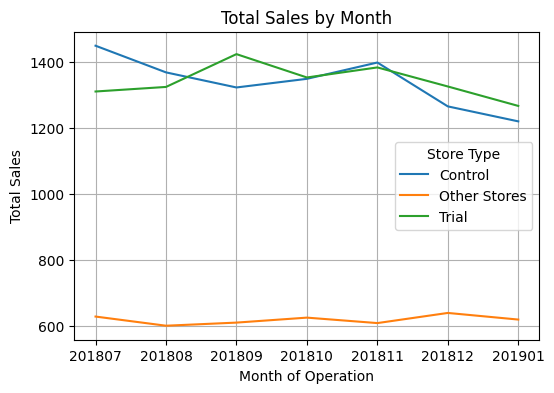

In [ ]:
plt.figure(figsize=(6, 4))
for store_type, group in past_sales.groupby('Store_Type'):  #define 'group' will be a DataFrame that contains all rows in the same store types(3 types here)
    plt.plot(group['MonthID'], group['Monthly_Sales'], label=store_type) #point the x-axis data, y-asix data and lable for the plot.
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.title('Total Sales by Month')
plt.legend(title='Store Type')
plt.grid(True)
plt.show()

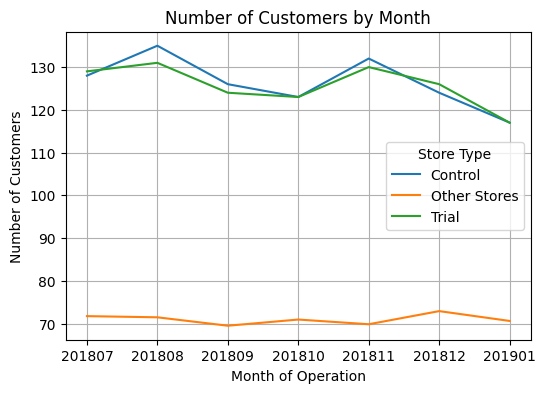

In [ ]:
# Visual checks on trends based on the drivers (number of customers)

# Calculate number of customers mean by MonthID and Store_type
past_cust = pretrial_df.groupby(['MonthID', 'Store_Type'])['nCustomers'].mean().reset_index()

# plot the result
plt.figure(figsize=(6, 4))
for store_type, group in past_cust.groupby('Store_Type'):
    plt.plot(group['MonthID'], group['nCustomers'], label=store_type)

plt.xlabel('Month of Operation')
plt.ylabel('Number of Customers')
plt.title('Number of Customers by Month')
plt.legend(title='Store Type')
plt.grid(True)
plt.show()

#### Summary: From the graphs, for trial & control store pair 88-237, total sales and total number of customers are quite similar.

## Assessment of Trial (Monthly Total Sales)
The trial period goes from the start of February 2019 to April 2019. We now want to see if there has been an uplift in overall chip sales.

Start with scaling the control store's sales to a level similar to control
for any differences between the two stores outside of the trial period.

In [ ]:
## Scale pre-trial control sales to match pre-trial trial store sales （201807-201901）
#measure_overtime_sales only include full observation data during pre-trial period

# Filter data for trial store and control store for pre-trial period
trial_store_sales = pretrial_df[(pretrial_df['STORE_NBR'] == trial_store)].copy()
control_store_sales = pretrial_df[(pretrial_df['STORE_NBR'] == control_store)].copy()

# Calculate the total sales for trial store and control store for the scaling factor
trial_store_totsales = trial_store_sales['Monthly_Sales'].sum()
control_store_totsales = control_store_sales['Monthly_Sales'].sum()
scalingF_control_sales = trial_store_totsales / control_store_totsales

# Apply the scaling factor to the control store sales in the dataset
control_store_sales['Scaled_Ctl_Sales'] = control_store_sales.apply(
    lambda x: x['Monthly_Sales'] * scalingF_control_sales if x['STORE_NBR'] == control_store else '-', axis=1)
control_store_sales

,STORE_NBR,MonthID,Monthly_Sales,nCustomers,Monthly_Trans,Total_Prod_Qty,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Store_Type,Scaled_Ctl_Sales
2747,237,201807,1448.4,128,162,324,1.265625,2.000000,4.470370,Control,1450.657086
2748,237,201808,1367.8,135,165,313,1.222222,1.896970,4.369968,Control,1369.931485
2749,237,201809,1322.2,126,149,299,1.182540,2.006711,4.422074,Control,1324.260425
2750,237,201810,1348.3,123,147,299,1.195122,2.034014,4.509365,Control,1350.401097
2751,237,201811,1397.6,132,161,320,1.219697,1.987578,4.367500,Control,1399.777923
2752,237,201812,1265.0,124,144,289,1.161290,2.006944,4.377163,Control,1266.971288
2753,237,201901,1219.7,117,139,277,1.188034,1.992806,4.403249,Control,1221.600696


In [ ]:
# Extract the columns we want, and calculate the percentage difference for pre-trial period
# Rename columns to avoid conflicts
trial_store_sales = trial_store_sales.rename(columns={'Monthly_Sales':'Trial_Sales', 'STORE_NBR':'Trial_Store_NBR'})
control_store_sales = control_store_sales.rename(columns={'Scaled_Ctl_Sales':'Control_Sales', 'STORE_NBR':'Ctl_Store_NBR'})

# Merge the two data frames on 'MonthID'
diff_pretrial = pd.merge(trial_store_sales[['MonthID', 'Trial_Sales', 'Trial_Store_NBR']],
                   control_store_sales[['MonthID', 'Control_Sales', 'Ctl_Store_NBR']],
                   on='MonthID')

# Calculate the percentage difference
diff_pretrial['Sales_Percent_Diff'] = (diff_pretrial['Trial_Sales']-diff_pretrial['Control_Sales']) / diff_pretrial['Control_Sales'] #set control store'sales as baseline for comparing

diff_pretrial[['MonthID','Ctl_Store_NBR','Control_Sales','Trial_Store_NBR','Trial_Sales','Sales_Percent_Diff']]

,MonthID,Ctl_Store_NBR,Control_Sales,Trial_Store_NBR,Trial_Sales,Sales_Percent_Diff
0,201807,237,1450.657086,88,1310.0,-0.096961
1,201808,237,1369.931485,88,1323.8,-0.033674
2,201809,237,1324.260425,88,1423.0,0.074562
3,201810,237,1350.401097,88,1352.4,0.001480
4,201811,237,1399.777923,88,1382.8,-0.012129
5,201812,237,1266.971288,88,1325.2,0.045959
6,201901,237,1221.600696,88,1266.4,0.036673


##### Now that we have comparable sales figures for the control store, we can calculate the percentage difference between the scaled control sales and the trial store's sales during the trial period(201902-201904).

In [ ]:
# Filter data for the trial period (201902-201904) for both trial and control stores
trial_store_sales_t = fullob_df[(fullob_df['STORE_NBR'] == trial_store)
                              & (fullob_df['MonthID'].astype(int) < 201905)
                              & (fullob_df['MonthID'].astype(int) > 201901)].copy()
control_store_sales_t = fullob_df[(fullob_df['STORE_NBR'] == control_store)
                                & (fullob_df['MonthID'].astype(int) < 201905)
                                & (fullob_df['MonthID'].astype(int) > 201901)].copy()

# Apply the scaling factor to the control store sales during trial period
control_store_sales_t['Scaled_Ctl_Sales'] = control_store_sales_t['Monthly_Sales'] * scalingF_control_sales

In [ ]:
# Rename columns to avoid conflicts
trial_store_sales_t = trial_store_sales_t.rename(columns={'Monthly_Sales':'Trial_Sales', 'STORE_NBR':'Trial_Store_NBR'})
control_store_sales_t = control_store_sales_t.rename(columns={'Scaled_Ctl_Sales':'Control_Sales', 'STORE_NBR':'Ctl_Store_NBR'})

# Merge the two data frames on 'MonthID'
diff_trial = pd.merge(trial_store_sales_t[['MonthID', 'Trial_Sales', 'Trial_Store_NBR']],
                   control_store_sales_t[['MonthID', 'Control_Sales', 'Ctl_Store_NBR']],
                   on='MonthID')

# Calculate the percentage difference
diff_trial['Sales_Percent_Diff'] = (diff_trial['Trial_Sales']-diff_trial['Control_Sales']) / diff_trial['Control_Sales'] #set control store'sales as baseline for comparing

diff_trial[['MonthID','Ctl_Store_NBR','Control_Sales','Trial_Store_NBR','Trial_Sales','Sales_Percent_Diff']].head()

,MonthID,Ctl_Store_NBR,Control_Sales,Trial_Store_NBR,Trial_Sales,Sales_Percent_Diff
0,201902,237,1406.989143,88,1370.2,-0.026147
1,201903,237,1210.082775,88,1477.2,0.220743
2,201904,237,1206.477165,88,1439.4,0.193060


##### As our null hypothesis is that the trial period is the same as the pre-trial period, let's take the standard deviation based on the scaled percentage difference in the pre-trial period.
- Null Hypothesis (𝐻0): The trial period is no different from the pre-trial period.

- Alternative Hypothesis (𝐻1): The trial period is different from the pre-trial period.

#### 1. Calculate the Standard Deviation for Pre-Trial Period:

In [ ]:
std_dev_pt = diff_pretrial['Sales_Percent_Diff'].std()
print(f"Standard deviation for pre-trial period: {std_dev_pt:.4f}")

Standard deviation for pre-trial period: 0.0572


#### 2. Calculate the T-values for the Trial Months:

In [ ]:
# Population mean (null hypothesis)
mu = 0

# Calculate t-values
t_values = (diff_trial['Sales_Percent_Diff'] - mu) / std_dev_pt # Use the sample standard deviation for pre-trial period, which provides a benchmark to measure deviations during the trial period.

# Display t-values
diff_trial.loc[:,'T_Value'] = t_values
diff_trial

,MonthID,Trial_Sales,Trial_Store_NBR,Control_Sales,Ctl_Store_NBR,Sales_Percent_Diff,T_Value
0,201902,1370.2,88,1406.989143,237,-0.026147,-0.456726
1,201903,1477.2,88,1210.082775,237,0.220743,3.855795
2,201904,1439.4,88,1206.477165,237,0.193060,3.372253


#### 3. Determine the Critical T-Value:

In [ ]:
# Degrees of freedom (df) ~ Pre-Trial Period
dof = len(diff_pretrial) - 1 # 7 months of data - 1

# Two-tailed test: significance level = 0.05
alpha = 0.05
t_critical = t.ppf(1 - alpha, dof)
print(f"Critical t-value for one-tailed test with df={dof}: {t_critical:.4f}")

Critical t-value for one-tailed test with df=6: 1.9432


#### 4. Compare the T-Values:
We can observe that the t-value in March is much larger than the critical t-value with 95% confidence interval. It could be the increase in sales in the trial store in March is statistically greater than in the control store.

#### 5. Visual Version of Comparison:
Let's create a more visual version of this by plotting the sales of the control store, the sales of the trial stores and the 95th percentile value of sales of the control store.

In [ ]:
## Method2: Filter data for all months with full observation periods and see the whole trend. (201807-201906)
trial_store_sales_f = fullob_df[fullob_df['STORE_NBR'] == trial_store].copy()
control_store_sales_f = fullob_df[fullob_df['STORE_NBR'] == control_store].copy()

# Apply the scaling factor to the control store sales during trial period
control_store_sales_f['Scaled_Ctl_Sales'] = control_store_sales_f['Monthly_Sales'] * scalingF_control_sales

# Rename columns to avoid conflicts
trial_store_sales_f = trial_store_sales_f.rename(columns={'Monthly_Sales':'Trial_Sales', 'STORE_NBR':'Trial_Store_NBR'})
control_store_sales_f = control_store_sales_f.rename(columns={'Scaled_Ctl_Sales':'Control_Sales', 'STORE_NBR':'Ctl_Store_NBR'})

# Merge the two data frames on 'MonthID'
diff_full = pd.merge(trial_store_sales_f[['MonthID', 'Trial_Sales', 'Trial_Store_NBR']],
                   control_store_sales_f[['MonthID', 'Control_Sales', 'Ctl_Store_NBR']],
                   on='MonthID')

# Calculate the percentage difference
diff_full['Percent_Diff'] = (diff_full['Trial_Sales']-diff_full['Control_Sales']) / diff_full['Control_Sales'] #set control store'sales as baseline for comparing

diff_full[['MonthID','Ctl_Store_NBR','Control_Sales','Trial_Store_NBR','Trial_Sales','Percent_Diff']]

,MonthID,Ctl_Store_NBR,Control_Sales,Trial_Store_NBR,Trial_Sales,Percent_Diff
0,201807,237,1450.657086,88,1310.00,-0.096961
1,201808,237,1369.931485,88,1323.80,-0.033674
2,201809,237,1324.260425,88,1423.00,0.074562
3,201810,237,1350.401097,88,1352.40,0.001480
4,201811,237,1399.777923,88,1382.80,-0.012129
5,201812,237,1266.971288,88,1325.20,0.045959
6,201901,237,1221.600696,88,1266.40,0.036673
7,201902,237,1406.989143,88,1370.20,-0.026147
8,201903,237,1210.082775,88,1477.20,0.220743
9,201904,237,1206.477165,88,1439.40,0.193060


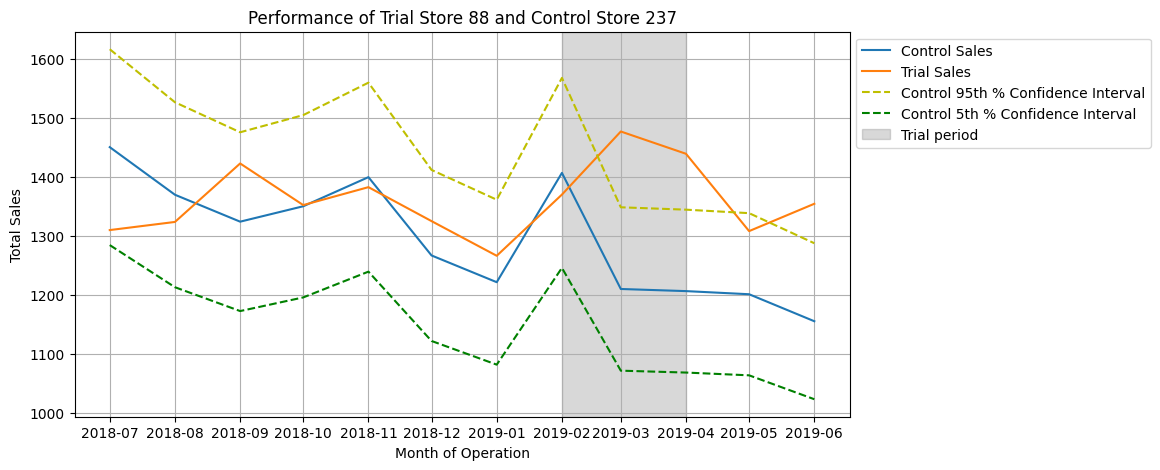

In [ ]:
plt.figure(figsize = (10,5))

# Convert MonthID to datetime format for x-axis
diff_full['MonthID'] = pd.to_datetime(diff_full['MonthID'], format='%Y%m')

# Plot the line graph of sales performance
plot_ctl = diff_full[(diff_full['Ctl_Store_NBR'] == control_store)][['MonthID', 'Ctl_Store_NBR', 'Control_Sales']]
plot_trial = diff_full[(diff_full['Trial_Store_NBR'] == trial_store)][['MonthID', 'Trial_Store_NBR', 'Trial_Sales']]

plt.plot(plot_ctl['MonthID'], plot_ctl['Control_Sales'], label='Control Sales')
plt.plot(plot_trial['MonthID'], plot_trial['Trial_Sales'], label='Trial Sales')

# plot the thresholds as lines
std_dev_pt = diff_pretrial['Sales_Percent_Diff'].std()
threshold95 = plot_ctl[['MonthID', 'Control_Sales']].copy()
threshold95['Control_Sales'] *= (1+std_dev_pt*2)
threshold5 = plot_ctl[['MonthID', 'Control_Sales']].copy()
threshold5['Control_Sales'] *= (1-std_dev_pt*2)

plt.plot(threshold95['MonthID'], threshold95['Control_Sales'], 'y--', label='Control 95th % Confidence Interval')
plt.plot(threshold5['MonthID'], threshold5['Control_Sales'], 'g--', label='Control 5th % Confidence Interval')

# Adding a shaded area to represent the trial period (February 2019 to April 2019)
plt.axvspan(pd.to_datetime('201902', format='%Y%m'), pd.to_datetime('201904', format='%Y%m'), color='gray', alpha=0.3, label='Trial period')

# Customize x-axis to show every month
months = pd.date_range(start='2018-07', #or lot_ctl['MonthID'].min()
                       end='2019-06',  #or lot_ctl['MonthID'].max()
                       freq='MS')  #frequence is Months
plt.xticks(months, [month.strftime('%Y-%m') for month in months], rotation=0)  # each tick mark corresponds to a month formatted as YYYY-MM

plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.title('Performance of Trial Store ' + str(trial_store) + ' and Control Store ' + str(control_store))
plt.grid(True)
plt.legend(loc = "upper left",bbox_to_anchor=(1, 1))
plt.show()

#### The results show that the trial in store 88 is significantly different to its control store in the trial period as the trial store performance lies outside of the 5% to 95% confidence interval of the control store in two of the three trial months.

## Assessment of Trial (Monthly Number of Customers)
This would be a repeat of the steps before for total sales:
- Scale pre-trial control customers to match pre-trial trial store customers.
- Compute a scaling factor to align control store customer counts to our trial store.
- Then, apply the scaling factor to control store customer counts.
- Finally, calculate the percentage difference between scaled control store customers and trial customers.

In [ ]:
## Scale pre-trial control customers to match pre-trial trial store customers (201807-201901)

# Filter data for trial store and control store before Feb 2019
trial_store_cust = pretrial_df[pretrial_df['STORE_NBR'] == trial_store].copy()
control_store_cust = pretrial_df[pretrial_df['STORE_NBR'] == control_store].copy()

# Calculate the number of customers for trial store and control store for the scaling factor
trial_store_ncust = trial_store_cust['nCustomers'].sum()
control_store_ncust = control_store_cust['nCustomers'].sum()
scalingF_control_ncust = trial_store_ncust / control_store_ncust

## Apply the scaling factor to the control store ncust in the dataset
control_store_cust.loc[:, 'Scaled_Ctl_nCustomers'] = control_store_cust.apply(
    lambda x: x['nCustomers'] * scalingF_control_ncust if x['STORE_NBR'] == control_store else '-', axis = 1)
control_store_cust

,STORE_NBR,MonthID,Monthly_Sales,nCustomers,Monthly_Trans,Total_Prod_Qty,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Store_Type,Scaled_Ctl_nCustomers
2747,237,201807,1448.4,128,162,324,1.265625,2.000000,4.470370,Control,127.276836
2748,237,201808,1367.8,135,165,313,1.222222,1.896970,4.369968,Control,134.237288
2749,237,201809,1322.2,126,149,299,1.182540,2.006711,4.422074,Control,125.288136
2750,237,201810,1348.3,123,147,299,1.195122,2.034014,4.509365,Control,122.305085
2751,237,201811,1397.6,132,161,320,1.219697,1.987578,4.367500,Control,131.254237
2752,237,201812,1265.0,124,144,289,1.161290,2.006944,4.377163,Control,123.299435
2753,237,201901,1219.7,117,139,277,1.188034,1.992806,4.403249,Control,116.338983


In [ ]:
# Extract the columns we want, and calculate the percentage difference for pre-trial period
# Rename columns to avoid conflicts
trial_store_cust = trial_store_cust.rename(columns={'nCustomers':'Trial_nCust', 'STORE_NBR':'Trial_Store_NBR'})
control_store_cust = control_store_cust.rename(columns={'Scaled_Ctl_nCustomers':'Ctl_nCust', 'STORE_NBR':'Ctl_Store_NBR'})

# Merge the two data frames on 'MonthID'
diff_pretrial = pd.merge(trial_store_cust[['MonthID', 'Trial_nCust', 'Trial_Store_NBR']],
                         control_store_cust[['MonthID', 'Ctl_nCust', 'Ctl_Store_NBR']],
                         on='MonthID')

# Calculate the percentage difference
diff_pretrial['nCust_Percent_Diff'] = (diff_pretrial['Trial_nCust']-diff_pretrial['Ctl_nCust']) / diff_pretrial['Ctl_nCust'] #set control store's number of customers as baseline for comparing

diff_pretrial[['MonthID','Ctl_Store_NBR','Ctl_nCust','Trial_Store_NBR','Trial_nCust','nCust_Percent_Diff']]

,MonthID,Ctl_Store_NBR,Ctl_nCust,Trial_Store_NBR,Trial_nCust,nCust_Percent_Diff
0,201807,237,127.276836,88,129,0.013539
1,201808,237,134.237288,88,131,-0.024116
2,201809,237,125.288136,88,124,-0.010281
3,201810,237,122.305085,88,123,0.005682
4,201811,237,131.254237,88,130,-0.009556
5,201812,237,123.299435,88,126,0.021902
6,201901,237,116.338983,88,117,0.005682


In [ ]:
# Filter data for the trial period (201902-201904) for both trial and control stores
trial_store_cust_t = fullob_df[(fullob_df['STORE_NBR'] == trial_store)
                              & (fullob_df['MonthID'].astype(int) < 201905)
                              & (fullob_df['MonthID'].astype(int) > 201901)].copy()
control_store_cust_t = fullob_df[(fullob_df['STORE_NBR'] == control_store)
                                & (fullob_df['MonthID'].astype(int) < 201905)
                                & (fullob_df['MonthID'].astype(int) > 201901)].copy()

# Apply the scaling factor to the control store sales during trial period
control_store_cust_t['Scaled_Ctl_nCust'] = control_store_cust_t['nCustomers'] * scalingF_control_ncust

# Rename columns to avoid conflicts
trial_store_cust_t = trial_store_cust_t.rename(columns={'nCustomers':'Trial_nCust', 'STORE_NBR':'Trial_Store_NBR'})
control_store_cust_t = control_store_cust_t.rename(columns={'Scaled_Ctl_nCustomers':'Ctl_nCust', 'STORE_NBR':'Ctl_Store_NBR'})

# Merge the two data frames on 'MonthID'
diff_trial = pd.merge(trial_store_cust[['MonthID', 'Trial_nCust', 'Trial_Store_NBR']],
                      control_store_cust[['MonthID', 'Ctl_nCust', 'Ctl_Store_NBR']],
                      on='MonthID')

# Calculate the percentage difference
diff_trial['nCust_Percent_Diff'] = (diff_trial['Trial_nCust']-diff_trial['Ctl_nCust']) / diff_trial['Ctl_nCust'] #set control store's ncust as baseline for comparing

diff_trial[['MonthID','Ctl_Store_NBR','Ctl_nCust','Trial_Store_NBR','Trial_nCust','nCust_Percent_Diff']]

,MonthID,Ctl_Store_NBR,Ctl_nCust,Trial_Store_NBR,Trial_nCust,nCust_Percent_Diff
0,201807,237,127.276836,88,129,0.013539
1,201808,237,134.237288,88,131,-0.024116
2,201809,237,125.288136,88,124,-0.010281
3,201810,237,122.305085,88,123,0.005682
4,201811,237,131.254237,88,130,-0.009556
5,201812,237,123.299435,88,126,0.021902
6,201901,237,116.338983,88,117,0.005682


##### As our null hypothesis is that the trial period is the same as the pre-trial period, let's take the standard deviation based on the scaled percentage difference in the pre-trial period.
- Null Hypothesis (𝐻0): The trial period is no different from the pre-trial period.

- Alternative Hypothesis (𝐻1): The trial period is different from the pre-trial period.

Steps:
1. Calculate the Standard Deviation for Pre-Trial Period
2. Calculate the T-values for the Trial Months
3. Determine the Critical T-Value
4. Compare the T-Values
5. Visual Version of Comparison

In [ ]:
## Step1: Calculate the std for the pre-trial months (201807-201901)
std_dev_pt = diff_pretrial['nCust_Percent_Diff'].std()
print(f"Standard deviation for pre-trial period: {std_dev_pt:.4f}")

Standard deviation for pre-trial period: 0.0158


In [ ]:
## Step2: Calculate the T-values for the Trial Months (201902-201904)
# Population mean (null hypothesis)
mu = 0

# Calculate t-values
t_values = (diff_trial['nCust_Percent_Diff'] - mu) / std_dev_pt # Use the sample standard deviation for pre-trial period, which provides a benchmark to measure deviations during the trial period.

# Display t-values
diff_trial.loc[:,'T_Value'] = t_values
diff_trial

,MonthID,Trial_nCust,Trial_Store_NBR,Ctl_nCust,Ctl_Store_NBR,nCust_Percent_Diff,T_Value
0,201807,129,88,127.276836,237,0.013539,0.854831
1,201808,131,88,134.237288,237,-0.024116,-1.522689
2,201809,124,88,125.288136,237,-0.010281,-0.649164
3,201810,123,88,122.305085,237,0.005682,0.358749
4,201811,130,88,131.254237,237,-0.009556,-0.603350
5,201812,126,88,123.299435,237,0.021902,1.382919
6,201901,117,88,116.338983,237,0.005682,0.358749


In [ ]:
## Step3: Determine the Critical T-Value
# Degrees of freedom (df) ~ Pre-Trial Period
dof = len(diff_pretrial) - 1 # 7 months of data - 1
alpha = 0.05
t_critical = t.ppf(1 - alpha, dof)
print(f"Critical t-value for one-tailed test with df={dof}: {t_critical:.4f}")

Critical t-value for one-tailed test with df=6: 1.9432


#### 4. Compare the T-Values:
We can observe that the t-value in March and April is much larger than the critical t-value with 95% confidence interval.

It could be the increase in number of customers in the trial store in March and April is statistically greater than in the control store.

In [ ]:
## Step 5: Visual Version of Comparison
# Filter data for all months with full observation periods and see the whole trend. (201807-201906)
trial_store_cust_f = fullob_df[fullob_df['STORE_NBR'] == trial_store].copy()
control_store_cust_f = fullob_df[fullob_df['STORE_NBR'] == control_store].copy()

# Apply the scaling factor to the control store sales during trial period
control_store_cust_f['Scaled_Ctl_nCustomers'] = control_store_cust_f['nCustomers'] * scalingF_control_ncust

# Rename columns to avoid conflicts
trial_store_cust_f = trial_store_cust_f.rename(columns={'nCustomers':'Trial_nCust', 'STORE_NBR':'Trial_Store_NBR'})
control_store_cust_f = control_store_cust_f.rename(columns={'Scaled_Ctl_nCustomers':'Ctl_nCust', 'STORE_NBR':'Ctl_Store_NBR'})

# Merge the two data frames on 'MonthID'
diff_full = pd.merge(trial_store_cust_f[['MonthID', 'Trial_nCust', 'Trial_Store_NBR']],
                      control_store_cust_f[['MonthID', 'Ctl_nCust', 'Ctl_Store_NBR']],
                      on='MonthID')

# Calculate the percentage difference
diff_full['nCust_Percent_Diff'] = (diff_full['Trial_nCust']-diff_full['Ctl_nCust']) / diff_full['Ctl_nCust'] #set control store's ncust as baseline for comparing

diff_full[['MonthID','Ctl_Store_NBR','Ctl_nCust','Trial_Store_NBR','Trial_nCust','nCust_Percent_Diff']]

,MonthID,Ctl_Store_NBR,Ctl_nCust,Trial_Store_NBR,Trial_nCust,nCust_Percent_Diff
0,201807,237,127.276836,88,129,0.013539
1,201808,237,134.237288,88,131,-0.024116
2,201809,237,125.288136,88,124,-0.010281
3,201810,237,122.305085,88,123,0.005682
4,201811,237,131.254237,88,130,-0.009556
5,201812,237,123.299435,88,126,0.021902
6,201901,237,116.338983,88,117,0.005682
7,201902,237,125.288136,88,124,-0.010281
8,201903,237,118.327684,88,134,0.132448
9,201904,237,119.322034,88,128,0.072727


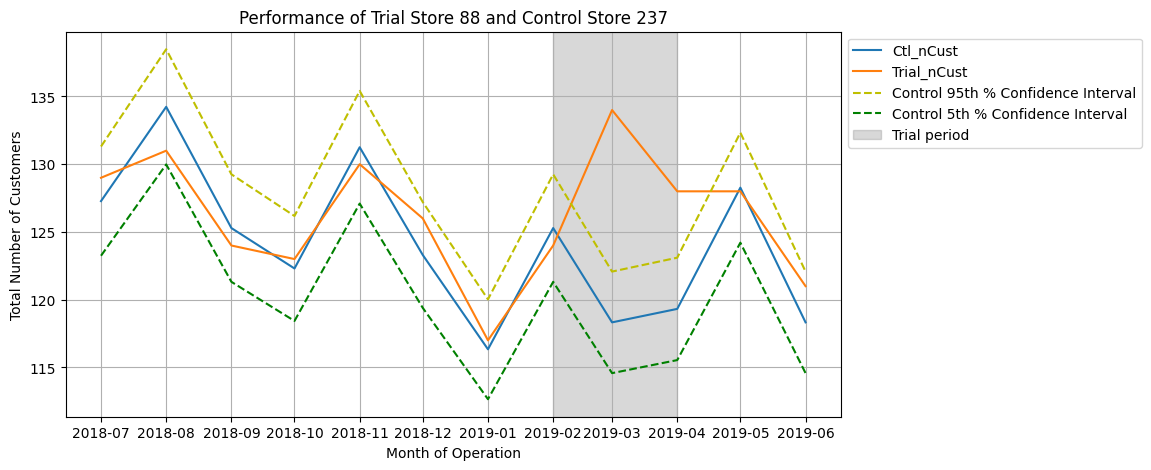

In [ ]:
plt.figure(figsize = (10,5))

# Convert MonthID to datetime format for x-axis
diff_full['MonthID'] = pd.to_datetime(diff_full['MonthID'], format='%Y%m')

# Plot the line graph of sales performance
plot_ctl = diff_full[(diff_full['Ctl_Store_NBR'] == control_store)][['MonthID', 'Ctl_Store_NBR', 'Ctl_nCust']]
plot_trial = diff_full[(diff_full['Trial_Store_NBR'] == trial_store)][['MonthID', 'Trial_Store_NBR', 'Trial_nCust']]

plt.plot(plot_ctl['MonthID'], plot_ctl['Ctl_nCust'], label='Ctl_nCust')
plt.plot(plot_trial['MonthID'], plot_trial['Trial_nCust'], label='Trial_nCust')

# plot the thresholds as lines
std_dev_pt = diff_pretrial['nCust_Percent_Diff'].std()
threshold95 = plot_ctl[['MonthID', 'Ctl_nCust']].copy()
threshold95['Ctl_nCust'] *= (1+std_dev_pt*2)
threshold5 = plot_ctl[['MonthID', 'Ctl_nCust']].copy()
threshold5['Ctl_nCust'] *= (1-std_dev_pt*2)

plt.plot(threshold95['MonthID'], threshold95['Ctl_nCust'], 'y--', label='Control 95th % Confidence Interval')
plt.plot(threshold5['MonthID'], threshold5['Ctl_nCust'], 'g--', label='Control 5th % Confidence Interval')

# Adding a shaded area to represent the trial period (February 2019 to April 2019)
plt.axvspan(pd.to_datetime('201902', format='%Y%m'), pd.to_datetime('201904', format='%Y%m'), color='gray', alpha=0.3, label='Trial period')

# Customize x-axis to show every month
months = pd.date_range(start='2018-07', #or lot_ctl['MonthID'].min()
                       end='2019-06',  #or lot_ctl['MonthID'].max()
                       freq='MS')  #frequence is Months
plt.xticks(months, [month.strftime('%Y-%m') for month in months], rotation=0)  # each tick mark corresponds to a month formatted as YYYY-MM

plt.xlabel('Month of Operation')
plt.ylabel('Total Number of Customers')
plt.title('Performance of Trial Store ' + str(trial_store) + ' and Control Store ' + str(control_store))
plt.grid(True)
plt.legend(loc = "upper left",bbox_to_anchor=(1, 1))
plt.show()

#### Total number of customers in the trial period for the trial store is significantly higher than the control store for two out of three months, which indicates a positive trial effect.

# Conclusion
We found control-trial stores pairs: (233-77), (155-86), and (237-88) respectively.
During the trial period, the results for trial stores 77 and 88 show a significant difference in at least two of the three trial months, but this is not the case for trial store 86. We can check with the client if the implementation of the trial was different in trial store 86 but overall, the trial shows a significant increase in sales.